In [2]:
import sys
sys.path.append('preLIMinary/')
sys.path.append('/home-2/gsatopo1@jhu.edu/library/my_lim')
from lim import lim
import numpy as np
import astropy.units as u
from LIM_lightcone import paint_lightcone, make_survey, make_measurements
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from scipy import integrate
import matplotlib
from scipy.optimize import curve_fit
import source.tools._utils as ut
import source.tools._vid_tools as vut
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as clrs
import matplotlib.cm as cmap
import matplotlib.patches as patches
import copy
import pmesh
from astropy.io import fits


import pickle

kitsune   = '#D9972F'
seiheki   = '#478384'
shuan     = '#740A00'
aonibi      = '#324356'
shion       = '#968ABD'
suoko     = '#B23E52'
shironeri    = '#FCFAF2'


colors = [suoko,seiheki,kitsune,'#79a43a',aonibi,shion,'#828282']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)
plt.rcParams['lines.linewidth'] = 3.0
plt.rcParams['axes.linewidth'] = 2.

palette=['#165783', '#cd9b00', '#ad321f', '#3c651e', '#9B88B5', '#5f685f']


In [3]:
def save_pickle(name,obj):
    '''
    name without extension
    '''
    with open(name+'.pickle', 'wb') as handle:
        pickle.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)
    return

def load_pickle(name):
    '''
    name without extensions
    '''
    with open(name+'.pickle', 'rb') as handle:
        obj = pickle.load(handle)
    return obj

In [3]:
koiai       = '#002E4E'
aiiro     = '#105779'
kujyaku   = '#008E74'
shuan     = '#740A00'
suo       = '#7E2639'
kitsune   = '#D9972F'
tamago    = '#FFDF85'
ominaeshi   = '#F2F2B0'
chojizome = '#DDB87E'
azuki     = '#A04940'
kitsune   = '#D9972F'
seiheki   = '#478384'
aonibi      = '#324356'
shion       = '#968ABD'



#map_blue = tri_map(koiai,aiiro,kujyaku)
#map_red = tri_map(shuan,suo,kitsune)

def tri_map(col1,col2,col3):
    cmap = clrs.LinearSegmentedColormap.from_list("", [col1,col2,col3])
    return cmap

def five_map(col1,col2,col3,col4,col5):
    cmap = clrs.LinearSegmentedColormap.from_list("", [col1,col2,col3,col4,col5])
    return cmap

map_blue = tri_map(koiai,kujyaku,ominaeshi)
map_red = tri_map(shuan,azuki,chojizome)#tamago)
map_br = five_map(koiai,seiheki,ominaeshi,kitsune,shuan)
map_br_3 = tri_map(koiai,ominaeshi,shuan)

def disptri(col1,col2,col3):
    f,axes = plt.subplots(figsize=(8,0.5), dpi=100,sharey=True)
    f.subplots_adjust(wspace=0,right=0.99,top=0.99,bottom=0.00,left=0.01,hspace=0.0)
    plt.yticks([])
    arr=np.tile(np.arange(1000),100).reshape(100,1000)
    cmap = tri_map(col1,col2,col3)
    plt.imshow(arr,cmap=cmap)
    
def disp5(col1,col2,col3,col4,col5):
    f,axes = plt.subplots(figsize=(8,0.5), dpi=100,sharey=True)
    f.subplots_adjust(wspace=0,right=0.99,top=0.99,bottom=0.00,left=0.01,hspace=0.0)
    plt.yticks([])
    arr=np.tile(np.arange(1000),100).reshape(100,1000)
    cmap = five_map(col1,col2,col3,col4,col5)
    plt.imshow(arr,cmap=cmap)

In [4]:
grey='#324356'
turquoise='#54858a'
#aqua='#5ca191'
yellow='#f0db92'
yellow_orange='#DDB87E'
orange='#C37854'

grey='#324356'
turquoise='#54858a'
#aqua='#5ca191'
yellow='#f0db92'
yellow_orange='#edc080'
orange='#C37854'
gabimap = matplotlib.colors.LinearSegmentedColormap.from_list("", [grey,turquoise,yellow,yellow_orange,orange])


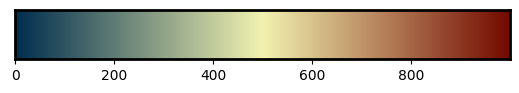

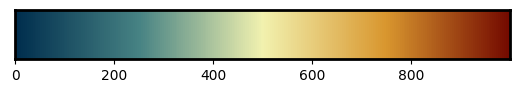

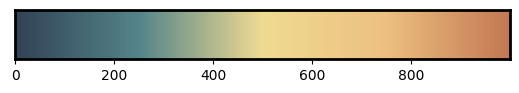

In [5]:
disptri(koiai,ominaeshi,shuan)
disp5(koiai,seiheki,ominaeshi,kitsune,shuan)
disp5(grey,turquoise,yellow, yellow_orange, orange)

In [6]:
def Dnu_from_Dz(nu,z,Dz):
    nuObs = nu/(1.+z)
    zmin = z-Dz/2.
    zmax = z+Dz/2.
    nu_zmin = nu/(1.+zmin)
    nu_zmax = nu/(1.+zmax)
    return nuObs, abs(nu_zmin-nu_zmax)

def LC_params(do_exSFR, exSFR, exSFR_pars, Tsys):
    nu_CO=115.271*u.GHz
    z_min = 2.4
    z_max = 3.4
    model_params=dict(halo_lightcone_dir='/home/jlbernal/LightCone_S82_UM', 
                      lines=dict(CO=True),
                      models=dict(CO=dict(model_name='CO_Li16',
                                          model_pars={'alpha':0.7,'beta':4.5,'delta_mf':1,'sigma_L':0.3})),
                      do_external_SFR = do_exSFR, external_SFR = exSFR,
                      SFR_pars=exSFR_pars,
                      supersample=1,
                      Nmu=10,
                      dk=0.02*u.Mpc**-1)
    obs_params=dict(zmin = z_min-0.03, zmax = z_max+0.03,
                    RAObs_min=-10*u.deg,RAObs_max=10*u.deg,
                    DECObs_min=-10*u.deg,DECObs_max=10*u.deg,
                    RA_min=-10*u.deg,RA_max=10*u.deg,
                    DEC_min=-10*u.deg,DEC_max=10*u.deg,
                    nuObs_max=nu_CO/(1+z_min), nuObs_min=nu_CO/(1+z_max),
                    beam_FWHM=4*u.arcmin,
                    dnu=15.6*u.MHz,
                    Tsys=Tsys*u.K, 
                    Nfeeds=1000, 
                    tobs=10000*u.hr,
                    linear_VID_bin=False, Tmin_VID = 1.0e-4*u.uK,
                    do_smooth=True)
    obs_params.update(model_params)
    return obs_params

# example plot

In [7]:
nu_CO=115.271*u.GHz
zmin_CO = 4.9
zmax_CO = 5.1

CO=make_measurements(dict(halo_lightcone_dir='/home/jlbernal/LightCone_S82_UM',
                          lines=dict(CO_J10=True),
                          target_line = 'CO_J10',
                          models=dict(CO_J10=dict(model_name='CO_lines_scaling_LFIR',
                                              model_pars={'alpha':1.09,'beta':-1,'sigma_L':0.3})),
                          do_external_SFR = False, external_SFR = '',
                          SFR_pars=dict(),
                          supersample=20,
                          Nmu=10,
                          dk=0.02*u.Mpc**-1,
                          zmin = zmin_CO-0.03, zmax = zmax_CO+0.03,
                          RAObs_min=-0.5*u.deg,RAObs_max=0.5*u.deg,
                          DECObs_min=-0.5*u.deg,DECObs_max=0.5*u.deg,
                          RA_min=-0.5*u.deg,RA_max=0.5*u.deg,
                          DEC_min=-0.5*u.deg,DEC_max=0.5*u.deg,
                          nuObs_max=nu_CO/(1+zmin_CO), nuObs_min=nu_CO/(1+zmax_CO),
                          beam_FWHM=4*u.arcmin,
                          dnu=31.25*u.MHz,
                          Tsys=0*u.K, 
                          Nfeeds=1000,
                          tobs=10000*u.hr,
                           LIR_pars = dict(IRX_name='Bouwens2020', log10Ms_IRX=9.15, alpha_IRX=0.97, sigma_IRX=0.2,
                                      K_IR=0.63*1.73e-10, K_UV=0.63*2.5e-10),
                          do_angular_smooth=True,
                          seed = 1213,do_intensity=False,do_downsample=False))

nu_CII=1900.539*u.GHz
zmin_CII = 4.9
zmax_CII = 5.1

factor = (u.Lsun/(1*u.erg/u.s)).decompose()

CII=make_measurements(dict(halo_lightcone_dir='/home/jlbernal/LightCone_S82_UM',
                          lines=dict(CII=True),
                           target_line = 'CII',
                          models=dict(CII=dict(model_name='SFR_scaling_relation_Kennicutt',
                                               model_pars={'K':10**7.06*factor,'Aext':0,'sigma_L':0.2})),
                           do_external_SFR = False, external_SFR = '',
                          SFR_pars=dict(),
                          supersample=15,
                          Nmu=10,
                          dk=0.02*u.Mpc**-1,
                          zmin = zmin_CII-0.03, zmax = zmax_CII+0.03,
                          RAObs_min=-0.5*u.deg,RAObs_max=0.5*u.deg,
                          DECObs_min=-0.5*u.deg,DECObs_max=0.5*u.deg,
                          RA_min=-0.5*u.deg,RA_max=0.5*u.deg,
                          DEC_min=-0.5*u.deg,DEC_max=0.5*u.deg,
                          nuObs_max=nu_CII/(1+zmin_CII), nuObs_min=nu_CII/(1+zmax_CII),
                          beam_FWHM=35*u.arcsec,
                          dnu=5.5*u.GHz,
                          Tsys=0*u.K, 
                          Nfeeds=1000,
                          tobs=10000*u.hr,
                          do_angular_smooth=True,
                          seed = 1213,do_intensity=True,do_downsample=False))

nu_Lya=2465398.5*u.GHz
zmin_Lya = 4.9
zmax_Lya = 5.1
Lya=make_measurements(dict(halo_lightcone_dir='/home/jlbernal/LightCone_S82_UM',
                          lines=dict(Lyalpha=True),
                           target_line = 'Lyalpha',
                          models=dict(Lyalpha=dict(model_name='Lyalpha_Chung19',model_pars={'C':1.6e42,'xi':1.6,'zeta':0.5,'psi':0.875,'z0':3.125,'f0':0.18,'SFR0':0.5,'sigma_L':0.3})),
                           do_external_SFR = False, external_SFR = '',
                          SFR_pars=dict(),
                          supersample=10,
                          Nmu=10,
                          dk=0.02*u.Mpc**-1,
                          zmin = zmin_Lya-0.03, zmax = zmax_Lya+0.03,
                          RAObs_min=-0.5*u.deg,RAObs_max=0.5*u.deg,
                          DECObs_min=-0.5*u.deg,DECObs_max=0.5*u.deg,
                          RA_min=-0.5*u.deg,RA_max=0.5*u.deg,
                          DEC_min=-0.5*u.deg,DEC_max=0.5*u.deg,
                          nuObs_max=nu_Lya/(1+zmin_Lya), nuObs_min=nu_Lya/(1+zmax_Lya),
                          beam_FWHM=6.2*u.arcsec,
                          dnu=17*u.THz,
                          Tsys=0*u.K, 
                          Nfeeds=1000,
                          tobs=10000*u.hr,
                          do_angular_smooth=True,
                          mass=True,
                          seed = 1213,do_intensity=True,do_downsample=False))

In [8]:
CO_map=CO.obs_3d_map
CII_map=CII.obs_3d_map
Lya_map=Lya.obs_3d_map

/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_214.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_215.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_216.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_214.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_215.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_216.fits


KeyboardInterrupt: 

In [9]:
Lya.update(Mstar_min = 10**9.5)
Lya_map_filt=Lya.obs_3d_map

In [10]:
ralim=np.asarray([CO.RAObs_min.value,CO.RAObs_max.value])
declim=np.asarray([CO.DECObs_min.value,CO.DECObs_max.value])
z_plot=np.asarray([CO.zmin, CO.zmax])
ra,dec  = np.deg2rad(ralim),np.deg2rad(declim)
x = np.cos(dec) * np.cos(ra)
y = np.cos(dec) * np.sin(ra)
z = np.sin(dec)
pos_lims = np.vstack([x,y,z]).T

r = ((CO.cosmo.comoving_radial_distance(z_plot)*u.Mpc).to(CO.Mpch)).value
grid_lim = r[:,None]*pos_lims

x=np.linspace(0, grid_lim[1,1]- grid_lim[0,1], CO.supersample*CO.Nside[0])
y=np.linspace(0, grid_lim[1,2]-grid_lim[0,2], CO.supersample*CO.Nside[1])

<ipython-input-48-82e8adf70db6>:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


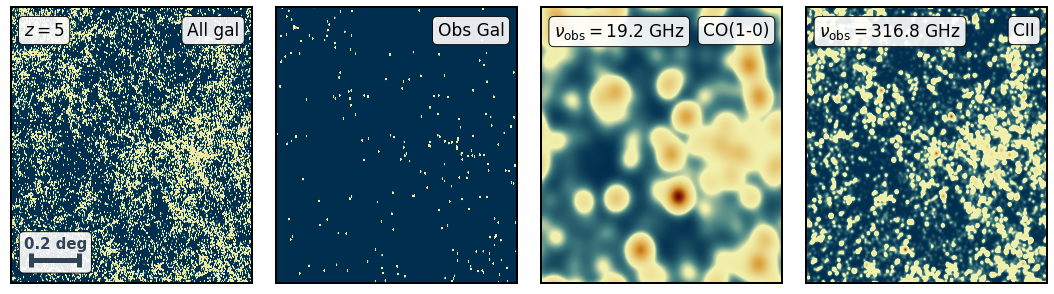

In [48]:

gs_plot = gridspec.GridSpec(1, 4,left=0.05,bottom=0.02,right=0.95,top=0.98,wspace=.1,hspace=.0)
fig = plt.figure(figsize=(16,4))

ax = plt.subplot(gs_plot[0,0])
norm = clrs.TwoSlopeNorm(vcenter=0)
ax.imshow(Lya_map.preview(axes=[2,1]), extent=[x[0],x[-1], y[-1], y[0]], cmap=map_br,norm=norm,aspect='auto')
#plt.xlabel('Mpc/h')
ax.text(89,5,'All gal', bbox=dict(boxstyle="round",facecolor='white', alpha=0.9),ha='right',fontsize=17,va='top')
ax.text(5,5,r'$z=5$', bbox=dict(boxstyle="round",facecolor='white', alpha=0.9),ha='left',fontsize=17,va='top')
ax.set_xticks([])
ax.set_yticks([])
rside = x[-1]-x[0]
side = rside/10
cent = 5+side+3
ax.text(cent,y[-1]-5,'0.2 deg\n', color=aonibi,weight='bold',ha='center',va='bottom',fontsize=15,bbox=dict(boxstyle="round",facecolor='white', alpha=0.9))
ax.errorbar(cent,y[-1]-8,xerr=side,marker='',ls='--',c=aonibi,elinewidth=5,capsize=7,capthick=5,zorder=10)

ax = plt.subplot(gs_plot[0,1])
norm = clrs.TwoSlopeNorm(vcenter=0)
ax.imshow(Lya_map_filt.preview(axes=[2,1]), extent=[x[0],x[-1], y[-1], y[0]], cmap=map_br,norm=norm,aspect='auto')
#plt.xlabel('Mpc/h')
ax.text(89,5,'Obs Gal', bbox=dict(boxstyle="round",facecolor='white', alpha=0.9),ha='right',fontsize=17,va='top')
ax.set_xticks([])
ax.set_yticks([])

ax = plt.subplot(gs_plot[0,2])
norm = clrs.TwoSlopeNorm(vcenter=0)
ax.imshow(CO_map.preview(axes=[2,1]), extent=[x[0],x[-1], y[-1], y[0]], cmap=map_br,norm=norm,aspect='auto')
#plt.xlabel('Mpc/h')
ax.text(89,5,'CO(1-0)', bbox=dict(boxstyle="round",facecolor='white', alpha=0.9),ha='right',fontsize=17,va='top')
ax.text(5,5,r'$\nu_{\rm obs}=$'+'${:.1f}$ GHz'.format(0.5*(CO.nuObs_max+CO.nuObs_min).value), bbox=dict(boxstyle="round",facecolor='white', alpha=0.9),ha='left',fontsize=17,va='top')
ax.set_xticks([])
ax.set_yticks([])

ax = plt.subplot(gs_plot[0,3])
norm = clrs.TwoSlopeNorm(vcenter=0)
ax.imshow(CII_map.preview(axes=[2,1]), extent=[x[0],x[-1], y[-1], y[0]], cmap=map_br,norm=norm,aspect='auto')
#plt.xlabel('Mpc/h')
ax.text(89,5,'CII', bbox=dict(boxstyle="round",facecolor='white', alpha=0.9),ha='right',fontsize=17,va='top')
ax.text(5,5,r'$\nu_{\rm obs}=$'+'${:.1f}$ GHz'.format(0.5*(CII.nuObs_max+CII.nuObs_min).value), bbox=dict(boxstyle="round",facecolor='white', alpha=0.9),ha='left',fontsize=17,va='top')
ax.set_xticks([])
ax.set_yticks([])

plt.tight_layout()
plt.savefig('LIM_maps.png', dpi=100)
plt.show()

In [49]:
np.savez('same_vol_maps.npz', Lya_map,Lya_map_filt,CO_map,CII_map)


In [52]:
CII.update(supersample=30)
CII_map=CII.obs_3d_map


In [53]:
ralim=np.asarray([CO.RAObs_min.value,CO.RAObs_max.value])
declim=np.asarray([CO.DECObs_min.value,CO.DECObs_max.value])
z_plot=np.asarray([CO.zmin, CO.zmax])
ra,dec  = np.deg2rad(ralim),np.deg2rad(declim)
x = np.cos(dec) * np.cos(ra)
y = np.cos(dec) * np.sin(ra)
z = np.sin(dec)
pos_lims = np.vstack([x,y,z]).T

r = ((CO.cosmo.comoving_radial_distance(z_plot)*u.Mpc).to(CO.Mpch)).value
grid_lim = r[:,None]*pos_lims

x=np.linspace(0, grid_lim[1,1]- grid_lim[0,1], CO.supersample*CO.Nside[0])
y=np.linspace(0, grid_lim[1,2]-grid_lim[0,2], CO.supersample*CO.Nside[1])

<ipython-input-54-e45b9cc7a2cf>:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


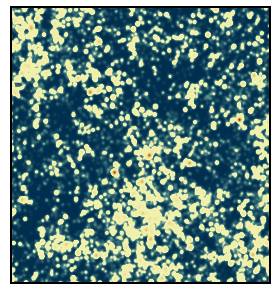

In [54]:
gs_plot = gridspec.GridSpec(1, 1,left=0.05,bottom=0.02,right=0.95,top=0.98,wspace=.1,hspace=.0)
fig = plt.figure(figsize=(4,4))

ax = plt.subplot(gs_plot[0,0])
norm = clrs.TwoSlopeNorm(vcenter=0)
ax.imshow(CII_map.preview(axes=[1,2]), extent=[x[0],x[-1], y[-1], y[0]], cmap=map_br,norm=norm,aspect='auto')
#plt.xlabel('Mpc/h')
#ax.text(89,5,'CII', bbox=dict(boxstyle="round",facecolor='white', alpha=0.9),ha='right',fontsize=17,va='top')
#ax.text(5,5,r'$\nu_{\rm obs}=$'+'${:.1f}$ GHz'.format(0.5*(CII.nuObs_max+CII.nuObs_min).value), bbox=dict(boxstyle="round",facecolor='white', alpha=0.9),ha='left',fontsize=17,va='top')
ax.set_xticks([])
ax.set_yticks([])

plt.tight_layout()
plt.savefig('CII_z5_maps.png', dpi=5000)
plt.show()

In [16]:
CO.update(supersample=40)

In [17]:
CO_map=CO.obs_3d_map


In [18]:
ralim=np.asarray([CO.RAObs_min.value,CO.RAObs_max.value])
declim=np.asarray([CO.DECObs_min.value,CO.DECObs_max.value])
z_plot=np.asarray([CO.zmin, CO.zmax])
ra,dec  = np.deg2rad(ralim),np.deg2rad(declim)
x = np.cos(dec) * np.cos(ra)
y = np.cos(dec) * np.sin(ra)
z = np.sin(dec)
pos_lims = np.vstack([x,y,z]).T

r = ((CO.cosmo.comoving_radial_distance(z_plot)*u.Mpc).to(CO.Mpch)).value
grid_lim = r[:,None]*pos_lims

x=np.linspace(0, grid_lim[1,1]- grid_lim[0,1], CO.supersample*CO.Nside[0])
y=np.linspace(0, grid_lim[1,2]-grid_lim[0,2], CO.supersample*CO.Nside[1])

<ipython-input-19-23669e3013e0>:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


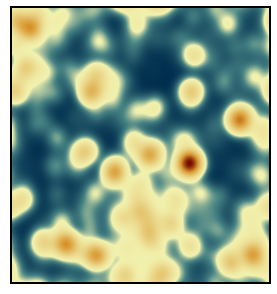

In [19]:
gs_plot = gridspec.GridSpec(1, 1,left=0.05,bottom=0.02,right=0.95,top=0.98,wspace=.1,hspace=.0)
fig = plt.figure(figsize=(4,4))

ax = plt.subplot(gs_plot[0,0])
norm = clrs.TwoSlopeNorm(vcenter=0)
ax.imshow(CO_map.preview(axes=[1,2]), extent=[x[0],x[-1], y[-1], y[0]], cmap=map_br,norm=norm,aspect='auto')
#plt.xlabel('Mpc/h')
#ax.text(89,5,'CO', bbox=dict(boxstyle="round",faceCOlor='white', alpha=0.9),ha='right',fontsize=17,va='top')
#ax.text(5,5,r'$\nu_{\rm obs}=$'+'${:.1f}$ GHz'.format(0.5*(CO.nuObs_max+CO.nuObs_min).value), bbox=dict(boxstyle="round",faceCOlor='white', alpha=0.9),ha='left',fontsize=17,va='top')
ax.set_xticks([])
ax.set_yticks([])

plt.tight_layout()
plt.savefig('CO_z5_maps.png', dpi=5000)
plt.show()

# Interloper plot

In [8]:
zmin,zmax = 0.32,5.52
nu_CII=1900.539*u.GHz
zmin_CIIobs,zmax_CIIobs = 4.5,5.5
LC=make_measurements(dict(halo_lightcone_dir='/home/jlbernal/LightCone_S82_UM',
                          lines=dict(CO_J43=True),
                          target_line = 'CII',
                          models=dict(CO_J43=dict(model_name='CO_lines_scaling_LFIR',
                                              model_pars={'alpha':1.09,'beta':1.2,'sigma_L':0.3})),
                          do_external_SFR = False, external_SFR = '',
                          SFR_pars=dict(),
                          supersample=12,
                          Nmu=20,
                          dk=0.02*u.Mpc**-1,
                          zmin = zmin, zmax = zmax,
                          RAObs_min=-0.5*u.deg,RAObs_max=0.5*u.deg,
                          DECObs_min=-0.5*u.deg,DECObs_max=0.5*u.deg,
                          RA_min=-0.5*u.deg,RA_max=0.5*u.deg,
                          DEC_min=-0.5*u.deg,DEC_max=0.5*u.deg,
                          nuObs_max=nu_CII/(1+zmin_CIIobs), nuObs_min=nu_CII/(1+zmax_CIIobs),
                          beam_FWHM=1*u.arcmin,
                          dnu=2.2*u.GHz,
                          Tsys=0*u.K, 
                          Nfeeds=1000,
                          tobs=10000*u.hr,
                           LIR_pars = dict(IRX_name='Bouwens2020', log10Ms_IRX=9.15, alpha_IRX=0.97, sigma_IRX=0.2,
                                      K_IR=0.63*1.73e-10, K_UV=0.63*2.5e-10),
                          do_angular_smooth=True,
                         seed=1234,do_intensity=True,do_downsample=False,do_remove_mean=True))


### Get quantities

In [9]:
CO_J43_map=LC.obs_3d_map
PkCO_J43=LC.Pk_0
kCO_J43=LC.k_Pk_poles

CO_J43_map_lowgrade = copy.copy(LC.obs_3d_map.r2c())
pm_noise = pmesh.pm.ParticleMesh(np.array([LC.Nchan,LC.Nside[0],LC.Nside[1]], dtype=int),
                                        BoxSize=LC.Lbox.value, dtype='float32', resampler='cic')
CO_J43_map_lowgrade = pm_noise.downsample(CO_J43_map_lowgrade.c2r(),keep_mean=True)

/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_36.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_37.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_38.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_39.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_40.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_41.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_42.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_43.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_44.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_45.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_46.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_47.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_48.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_49.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_50.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_51.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_52.fits
/home/jlbernal

/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_176.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_177.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_178.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_179.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_180.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_181.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_182.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_183.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_184.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_185.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_186.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_187.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_188.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_189.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_190.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_191.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_192.fi

In [10]:
Nbins=50
Ie_COJ43 = np.logspace(0,np.log10(2e4),Nbins+1)*LC.unit       
Ii_COJ43 = 0.5*(Ie_COJ43[:-1]+Ie_COJ43[1:])
VID_COJ43 = np.histogram(CO_J43_map_lowgrade.value.flatten(),
                            bins=Ie_COJ43.value)[0]

In [11]:
LC.update(lines=dict(CO_J65=True),
          models=dict(CO_J65=dict(model_name='CO_lines_scaling_LFIR',
                                  model_pars={'alpha':1.04,'alpha_std':0.033,'beta':2.2,'beta_std':0.2,'sigma_L':0.3})))


In [12]:
CO_J65_map=LC.obs_3d_map
PkCO_J65=LC.Pk_0
kCO_J65=LC.k_Pk_poles

CO_J65_map_lowgrade = copy.copy(LC.obs_3d_map.r2c())
pm_noise = pmesh.pm.ParticleMesh(np.array([LC.Nchan,LC.Nside[0],LC.Nside[1]], dtype=int),
                                        BoxSize=LC.Lbox.value, dtype='float32', resampler='cic')
CO_J65_map_lowgrade = pm_noise.downsample(CO_J65_map_lowgrade.c2r(),keep_mean=True)

In [13]:
Nbins=50
Ie_COJ65 = np.logspace(0,np.log10(2e4),Nbins+1)*LC.unit            
Ii_COJ65 = 0.5*(Ie_COJ65[:-1]+Ie_COJ65[1:])
VID_COJ65 = np.histogram(CO_J65_map_lowgrade.value.flatten(),
                            bins=Ie_COJ65.value)[0]

In [14]:
factor = (u.Lsun/(1*u.erg/u.s)).decompose()

LC.update(lines=dict(CII=True),
        models=dict(CII=dict(model_name='SFR_scaling_relation_Kennicutt',
                                               model_pars={'K':10**7.06*factor,'Aext':0,'sigma_L':0.2})))


In [15]:
CII_map=LC.obs_3d_map
PkCII=LC.Pk_0
kCII=LC.k_Pk_poles

CII_map_lowgrade = copy.copy(LC.obs_3d_map.r2c())
pm_noise = pmesh.pm.ParticleMesh(np.array([LC.Nchan,LC.Nside[0],LC.Nside[1]], dtype=int),
                                        BoxSize=LC.Lbox.value, dtype='float32', resampler='cic')
CII_map_lowgrade = pm_noise.downsample(CII_map_lowgrade.c2r(),keep_mean=True)

In [16]:
Nbins=50
Ie_CII = np.logspace(0,np.log10(2e4),Nbins+1)*LC.unit             
Ii_CII = 0.5*(Ie_CII[:-1]+Ie_CII[1:])
VID_CII = np.histogram(CII_map_lowgrade.value.flatten(),
                            bins=Ie_CII.value)[0]

In [17]:
from nbodykit.algorithms import FFTPower
from nbodykit.source.mesh.catalog import CompensateCICShotnoise


In [18]:
ALL_map = CO_J43_map + CO_J65_map + CII_map

ALL_map = (ALL_map.r2c().apply(CompensateCICShotnoise, kind='circular')).c2r()
    
Pk2dALL = FFTPower(ALL_map, '2d', Nmu=LC.Nmu, poles=[0,2,4], los=[1,0,0],
                                dk=LC.dk.to(LC.Mpch**-1).value,kmin=LC.kmin.to(LC.Mpch**-1).value,
                                kmax=LC.kmax.to(LC.Mpch**-1).value,BoxSize=LC.Lbox.value)

PkALL=(Pk2dALL.poles['power_0'].real*LC.Mpch**3).to(LC.Mpch**3)*LC.unit**2

kALL=(Pk2dALL.poles['k']*LC.Mpch**-1).to(LC.Mpch**-1)

ALL_map_lowgrade = copy.copy(ALL_map.r2c())
pm_noise = pmesh.pm.ParticleMesh(np.array([LC.Nchan,LC.Nside[0],LC.Nside[1]], dtype=int),
                                        BoxSize=LC.Lbox.value, dtype='float32', resampler='cic')
ALL_map_lowgrade = pm_noise.downsample(ALL_map_lowgrade.c2r(),keep_mean=True)

In [19]:
Nbins=50
Ie_ALL = np.logspace(0,np.log10(2e4),Nbins+1)*LC.unit           
Ii_ALL = 0.5*(Ie_ALL[:-1]+Ie_ALL[1:])
VID_ALL = np.histogram(ALL_map_lowgrade.value.flatten(),
                            bins=Ie_ALL.value)[0]

### Make the plots

In [20]:
ralim=np.asarray([LC.RAObs_min.value,LC.RAObs_max.value])
declim=np.asarray([LC.DECObs_min.value,LC.DECObs_max.value])
z_plot=np.asarray([zmin_CIIobs,zmax_CIIobs])
ra,dec  = np.deg2rad(ralim),np.deg2rad(declim)
x = np.cos(dec) * np.cos(ra)
y = np.cos(dec) * np.sin(ra)
z = np.sin(dec)
pos_lims = np.vstack([x,y,z]).T

r = ((LC.cosmo.comoving_radial_distance(z_plot)*u.Mpc).to(LC.Mpch)).value
grid_lim = r[:,None]*pos_lims

x=np.linspace(0, grid_lim[1,1]- grid_lim[0,1], LC.supersample*LC.Nside[0])
y=np.linspace(0, grid_lim[1,2]-grid_lim[0,2], LC.supersample*LC.Nside[1])

<ipython-input-21-9303bfacb77b>:133: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


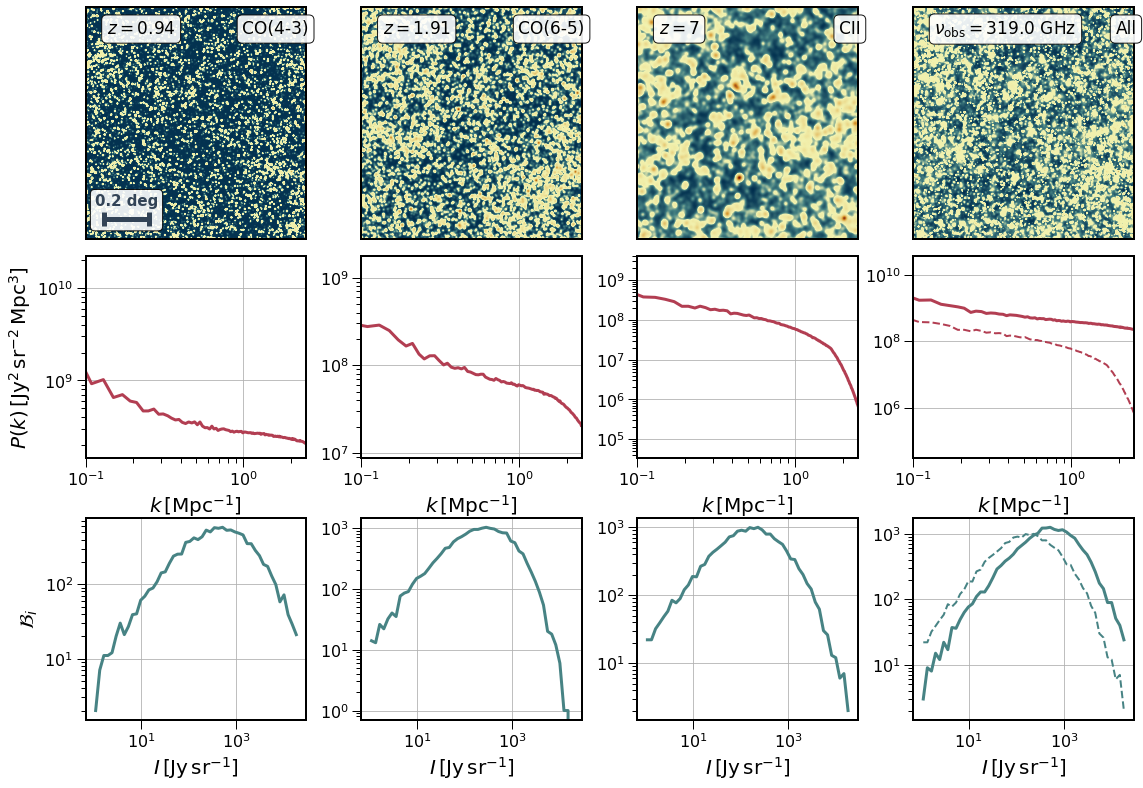

In [21]:
gs_plot = gridspec.GridSpec(2, 4,left=0.07,bottom=0.08,right=0.98,top=0.98,
                            wspace=.25,hspace=.05,height_ratios=[1,2])
fig = plt.figure(figsize=(16,11))

######## MAPS ########

ax = plt.subplot(gs_plot[0,0])
#norm = clrs.TwoSlopeNorm(vcenter=0,vmin=np.min(CO_J43_map.preview(axes=[2,1]),vmax=np.max(np.max(CO_J43_map.preview(axes=[2,1]))))
norm = clrs.TwoSlopeNorm(vcenter=0)
ax.imshow(CO_J43_map.preview(axes=[2,1]), extent=[x[0],x[-1], y[-1], y[0]], cmap=map_br,norm=norm,aspect='auto')
#plt.xlabel('Mpc/h')
ax.text(95,11,'CO(4-3)', bbox=dict(boxstyle="round",facecolor='white', alpha=0.9),ha='right',fontsize=17)
ax.text(9,11,r'$z=0.94$', bbox=dict(boxstyle="round",facecolor='white', alpha=0.9),ha='left',fontsize=17)
ax.set_xticks([])
ax.set_yticks([])
rside = x[-1]-x[0]
side = rside/10
cent = 5+side+3
ax.text(cent,y[-1]-5,'0.2 deg\n', color=aonibi,weight='bold',ha='center',va='bottom',fontsize=15,bbox=dict(boxstyle="round",facecolor='white', alpha=0.9))
ax.errorbar(cent,y[-1]-8,xerr=side,marker='',ls='--',c=aonibi,elinewidth=5,capsize=7,capthick=5,zorder=10)
#rside = x[-1]-x[0]
#cent = rside/5
#side = rside/10
#ax.errorbar(cent,y[-1]-7,xerr=side,marker='',ls='--',c=shironeri,elinewidth=5,capsize=10,capthick=5)
#ax.text(cent,y[-1]-10,r'0.2 deg', color=shironeri,weight='bold',ha='center',va='bottom')

ax = plt.subplot(gs_plot[0,1])
#norm = clrs.TwoSlopeNorm(vcenter=0,vmin=np.min(CO_J65_map.preview(axes=[2,1])),vmax=np.max(np.max(CO_J65_map.preview(axes=[2,1]))))
norm = clrs.TwoSlopeNorm(vcenter=0)
ax.imshow(CO_J65_map.preview(axes=[2,1]), extent=[x[0],x[-1], y[-1], y[0]], cmap=map_br,norm=norm,aspect='auto')
#plt.xlabel('Mpc/h')
ax.text(95,11,'CO(6-5)', bbox=dict(boxstyle="round",facecolor='white', alpha=0.9),ha='right',fontsize=17)
ax.text(9,11,r'$z=1.91$', bbox=dict(boxstyle="round",facecolor='white', alpha=0.9),ha='left',fontsize=17)
ax.set_xticks([])
ax.set_yticks([])


ax = plt.subplot(gs_plot[0,2])
#norm = clrs.TwoSlopeNorm(vcenter=0,vmin=np.min(CII_map.preview(axes=[2,1])),vmax=np.max(np.max(CII_map.preview(axes=[2,1]))))
norm = clrs.TwoSlopeNorm(vcenter=0)
ax.imshow(CII_map.preview(axes=[2,1]), extent=[x[0],x[-1], y[-1], y[0]], cmap=map_br,norm=norm,aspect='auto')
#plt.xlabel('Mpc/h')
ax.text(95,11,'CII', bbox=dict(boxstyle="round",facecolor='white', alpha=0.9),ha='right',fontsize=17)
ax.text(9,11,r'$z=7$', bbox=dict(boxstyle="round",facecolor='white', alpha=0.9),ha='left',fontsize=17)
ax.set_xticks([])
ax.set_yticks([])

ax = plt.subplot(gs_plot[0,3])
#norm = clrs.TwoSlopeNorm(vcenter=0,vmin=np.min(ALL_map.preview(axes=[2,1])),vmax=np.max(np.max(ALL_map.preview(axes=[2,1]))))
norm = clrs.TwoSlopeNorm(vcenter=0)
ax.imshow(ALL_map.preview(axes=[2,1]), extent=[x[0],x[-1], y[-1], y[0]], cmap=map_br,norm=norm,aspect='auto')
#plt.xlabel('Mpc/h')
ax.text(95,11,'All', bbox=dict(boxstyle="round",facecolor='white', alpha=0.9),ha='right',fontsize=17)
ax.text(9,11,r'$\nu_{\rm obs}=$'+'${:.1f}$ GHz'.format(0.5*(LC.nuObs_max+LC.nuObs_min).value), bbox=dict(boxstyle="round",facecolor='white', alpha=0.9),ha='left',fontsize=17)
ax.set_xticks([])
ax.set_yticks([])

######## PK ########

gs_plot2 = gridspec.GridSpecFromSubplotSpec(2, 4, subplot_spec=gs_plot[1,:],hspace=0.3,wspace=0.25)

ax = plt.subplot(gs_plot2[0,0])
ax.loglog(kCO_J43.to(u.Mpc**-1), PkCO_J43.to(LC.unit**2*u.Mpc**3))
ax.tick_params(axis='both',width=1,length=9,labelsize=16)
ax.tick_params(axis='both',which='minor',width=1,length=5,labelsize=16)
ax.grid()
ax.set_xlim(0.1,2.5)
#ax.set_ylim(1e5,1e6)
ax.set_xlabel(r'$k\,[{\rm Mpc^{-1}}]$',fontsize=20)
ax.set_ylabel(r'$P(k)\,[{\rm Jy^2\,sr^{-2}\,Mpc^{3}}]$',fontsize=20)

ax = plt.subplot(gs_plot2[0,1])
ax.loglog(kCO_J65.to(u.Mpc**-1), PkCO_J65.to(LC.unit**2*u.Mpc**3))
ax.tick_params(axis='both',width=1,length=9,labelsize=16)
ax.tick_params(axis='both',which='minor',width=1,length=5,labelsize=16)
ax.set_xlim(0.1,2.5)
#ax.set_ylim(5e2,1e4)
ax.grid()
ax.set_xlabel(r'$k\,[{\rm Mpc^{-1}}]$',fontsize=20)

ax = plt.subplot(gs_plot2[0,2])
ax.loglog(kCII.to(u.Mpc**-1), PkCII.to(LC.unit**2*u.Mpc**3))
ax.tick_params(axis='both',width=1,length=9,labelsize=16)
ax.tick_params(axis='both',which='minor',width=1,length=5,labelsize=16)
ax.set_xlim(0.1,2.5)
#ax.set_ylim(1e10,6e11)
ax.grid()
ax.set_xlabel(r'$k\,[{\rm Mpc^{-1}}]$',fontsize=20)

ax = plt.subplot(gs_plot2[0,3])
ax.loglog(kALL.to(u.Mpc**-1), PkALL.to(LC.unit**2*u.Mpc**3))
ax.loglog(kCII.to(u.Mpc**-1), PkCII.to(LC.unit**2*u.Mpc**3),lw=2,ls='--',color=colors[0])
ax.tick_params(axis='both',width=1,length=9,labelsize=16)
ax.tick_params(axis='both',which='minor',width=1,length=5,labelsize=16)
ax.set_xlim(0.1,2.5)
#ax.set_ylim(1e10,6e11)
ax.grid()
ax.set_xlabel(r'$k\,[{\rm Mpc^{-1}}]$',fontsize=20)

######## VID #######

ax = plt.subplot(gs_plot2[1,0])
ax.loglog(Ii_COJ43, VID_COJ43,color=colors[1])
ax.tick_params(axis='both',width=1,length=9,labelsize=16)
ax.tick_params(axis='both',which='minor',width=1,length=5,labelsize=16)
ax.grid()
ax.set_xlabel(r'$I\,[{\rm Jy\,sr^{-1}}]$',fontsize=20)
ax.set_ylabel(r'$\mathcal{B}_i$',fontsize=20)

ax = plt.subplot(gs_plot2[1,1])
ax.loglog(Ii_COJ65, VID_COJ65,color=colors[1])
ax.tick_params(axis='both',width=1,length=9,labelsize=16)
ax.tick_params(axis='both',which='minor',width=1,length=5,labelsize=16)
ax.grid()
ax.set_xlabel(r'$I\,[{\rm Jy\,sr^{-1}}]$',fontsize=20)

ax = plt.subplot(gs_plot2[1,2])
ax.loglog(Ii_CII, VID_CII,color=colors[1])
ax.tick_params(axis='both',width=1,length=9,labelsize=16)
ax.tick_params(axis='both',which='minor',width=1,length=5,labelsize=16)
ax.grid()
ax.set_xlabel(r'$I\,[{\rm Jy\,sr^{-1}}]$',fontsize=20)

ax = plt.subplot(gs_plot2[1,3])
ax.loglog(Ii_ALL, VID_ALL,color=colors[1])
ax.loglog(Ii_ALL, VID_CII,color=colors[1],lw=2,ls='--')

ax.tick_params(axis='both',width=1,length=9,labelsize=16)
ax.tick_params(axis='both',which='minor',width=1,length=5,labelsize=16)
ax.grid()
ax.set_xlabel(r'$I\,[{\rm Jy\,sr^{-1}}]$',fontsize=20)

plt.tight_layout()
plt.savefig('LIM_interloper_maps.png', dpi=100)
plt.show()

In [22]:
np.savez('interlopers.npz',CO43=CO_J43_map,CO65=CO_J65_map,CII=CII_map,ALL=ALL_map)

In [23]:
CO43q = dict(k=kCO_J43.to(u.Mpc**-1),Pk=PkCO_J43.to(LC.unit**2*u.Mpc**3),I=Ii_COJ43,VID=VID_COJ43)
CO65q = dict(k=kCO_J65.to(u.Mpc**-1),Pk=PkCO_J65.to(LC.unit**2*u.Mpc**3),I=Ii_COJ65,VID=VID_COJ65)
CIIq = dict(k=kCII.to(u.Mpc**-1),Pk=PkCII.to(LC.unit**2*u.Mpc**3),I=Ii_CII,VID=VID_CII)
ALLq = dict(k=kALL.to(u.Mpc**-1),Pk=PkALL.to(LC.unit**2*u.Mpc**3),I=Ii_ALL,VID=VID_ALL)

In [24]:
save_pickle('interlop_CO43q',CO43q)
save_pickle('interlop_CO65q',CO65q)
save_pickle('interlop_CIIq',CIIq)
save_pickle('interlop_ALLq',ALLq)

# Interlopers LC paper

In [10]:
zmin,zmax = 0.17,6.7
nu_CII=1900.539*u.GHz
zmin_CIIobs,zmax_CIIobs = 4.5,5.5
LC=make_measurements(dict(halo_lightcone_dir='/home/jlbernal/LightCone_S82_UM',
                          lines=dict(CO_J32=True),
                          target_line = 'CII',
                          models=dict(CO_J32=dict(model_name='CO_lines_scaling_LFIR',
                                              model_pars={'alpha':1.18,'beta':0.1,'sigma_L':0.3})),
                          do_external_SFR = False, external_SFR = '',
                          SFR_pars=dict(),
                          supersample=6,
                          Nmu=20,
                          dk=0.02*u.Mpc**-1,
                          zmin = zmin, zmax = zmax,
                          RAObs_min=-1*u.deg,RAObs_max=1*u.deg,
                          DECObs_min=-1*u.deg,DECObs_max=1*u.deg,
                          RA_min=-1*u.deg,RA_max=1*u.deg,
                          DEC_min=-1*u.deg,DEC_max=1*u.deg,
                          nuObs_max=290*u.GHz, nuObs_min=250*u.GHz,
                          beam_FWHM=58*u.arcsec,
                          dnu=2.8*u.GHz,
                          Tsys=0*u.Jy*u.s**(1./2)/u.sr, #Tsys=5.6921e5*u.Jy*u.s**(1./2)/u.sr, 
                          Nfeeds=1000,
                          tobs=10000*u.hr,
                           LIR_pars = dict(IRX_name='Bouwens2020', log10Ms_IRX=9.15, alpha_IRX=0.97, sigma_IRX=0.2,
                                      K_IR=0.63*1.73e-10, K_UV=0.63*2.5e-10),
                          do_angular_smooth=True,
                         seed=1234,do_intensity=True,do_downsample=False,do_remove_mean=True))


In [11]:
CO_J32_map=LC.obs_3d_map
PkCO_J32=LC.Pk_0
kCO_J32=LC.k_Pk_poles

CO_J32_map_lowgrade = copy.copy(LC.obs_3d_map.r2c())
pm_noise = pmesh.pm.ParticleMesh(np.array([LC.Nchan,LC.Nside[0],LC.Nside[1]], dtype=int),
                                        BoxSize=LC.Lbox.value, dtype='float32', resampler='cic')
CO_J32_map_lowgrade = pm_noise.downsample(CO_J32_map_lowgrade.c2r(),keep_mean=True)

Nbins=50
Ie_COJ32 = np.logspace(0,np.log10(2e4),Nbins+1)*LC.unit       
Ii_COJ32 = 0.5*(Ie_COJ32[:-1]+Ie_COJ32[1:])
VID_COJ32 = np.histogram(CO_J32_map_lowgrade.value.flatten(),
                            bins=Ie_COJ32.value)[0]

/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_20.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_21.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_22.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_23.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_24.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_25.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_26.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_27.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_28.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_29.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_30.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_31.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_32.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_33.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_34.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_35.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_36.fits
/home/jlbernal

/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_161.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_162.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_163.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_164.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_165.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_166.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_167.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_168.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_169.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_170.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_171.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_172.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_173.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_174.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_175.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_176.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_177.fi

In [12]:
LC.update(lines=dict(CO_J43=True),
          models=dict(CO_J43=dict(model_name='CO_lines_scaling_LFIR',
                                  model_pars={'alpha':1.09,'beta':1.2,'sigma_L':0.3})))


In [13]:
CO_J43_map=LC.obs_3d_map
PkCO_J43=LC.Pk_0
kCO_J43=LC.k_Pk_poles

CO_J43_map_lowgrade = copy.copy(LC.obs_3d_map.r2c())
pm_noise = pmesh.pm.ParticleMesh(np.array([LC.Nchan,LC.Nside[0],LC.Nside[1]], dtype=int),
                                        BoxSize=LC.Lbox.value, dtype='float32', resampler='cic')
CO_J43_map_lowgrade = pm_noise.downsample(CO_J43_map_lowgrade.c2r(),keep_mean=True)

Nbins=50
Ie_COJ43 = np.logspace(0,np.log10(2e4),Nbins+1)*LC.unit       
Ii_COJ43 = 0.5*(Ie_COJ43[:-1]+Ie_COJ43[1:])
VID_COJ43 = np.histogram(CO_J43_map_lowgrade.value.flatten(),
                            bins=Ie_COJ43.value)[0]

In [14]:
LC.update(lines=dict(CO_J54=True),
          models=dict(CO_J54=dict(model_name='CO_lines_scaling_LFIR',
                                  model_pars={'alpha':1.05,'beta':1.8,'sigma_L':0.3})))


In [15]:
CO_J54_map=LC.obs_3d_map
PkCO_J54=LC.Pk_0
kCO_J54=LC.k_Pk_poles

CO_J54_map_lowgrade = copy.copy(LC.obs_3d_map.r2c())
pm_noise = pmesh.pm.ParticleMesh(np.array([LC.Nchan,LC.Nside[0],LC.Nside[1]], dtype=int),
                                        BoxSize=LC.Lbox.value, dtype='float32', resampler='cic')
CO_J54_map_lowgrade = pm_noise.downsample(CO_J54_map_lowgrade.c2r(),keep_mean=True)

Nbins=50
Ie_COJ54 = np.logspace(0,np.log10(2e4),Nbins+1)*LC.unit       
Ii_COJ54 = 0.5*(Ie_COJ54[:-1]+Ie_COJ54[1:])
VID_COJ54 = np.histogram(CO_J54_map_lowgrade.value.flatten(),
                            bins=Ie_COJ54.value)[0]

In [16]:
LC.update(lines=dict(CO_J65=True),
          models=dict(CO_J65=dict(model_name='CO_lines_scaling_LFIR',
                                  model_pars={'alpha':1.04,'beta':2.2,'sigma_L':0.3})))


In [17]:
CO_J65_map=LC.obs_3d_map
PkCO_J65=LC.Pk_0
kCO_J65=LC.k_Pk_poles

CO_J65_map_lowgrade = copy.copy(LC.obs_3d_map.r2c())
pm_noise = pmesh.pm.ParticleMesh(np.array([LC.Nchan,LC.Nside[0],LC.Nside[1]], dtype=int),
                                        BoxSize=LC.Lbox.value, dtype='float32', resampler='cic')
CO_J65_map_lowgrade = pm_noise.downsample(CO_J65_map_lowgrade.c2r(),keep_mean=True)

Nbins=50
Ie_COJ65 = np.logspace(0,np.log10(2e4),Nbins+1)*LC.unit       
Ii_COJ65 = 0.5*(Ie_COJ65[:-1]+Ie_COJ65[1:])
VID_COJ65 = np.histogram(CO_J65_map_lowgrade.value.flatten(),
                            bins=Ie_COJ65.value)[0]

In [18]:
LC.update(lines=dict(CO_J76=True),
          models=dict(CO_J76=dict(model_name='CO_lines_scaling_LFIR',
                                  model_pars={'alpha':0.98,'beta':2.9,'sigma_L':0.3})))


In [19]:
CO_J76_map=LC.obs_3d_map
PkCO_J76=LC.Pk_0
kCO_J76=LC.k_Pk_poles

CO_J76_map_lowgrade = copy.copy(LC.obs_3d_map.r2c())
pm_noise = pmesh.pm.ParticleMesh(np.array([LC.Nchan,LC.Nside[0],LC.Nside[1]], dtype=int),
                                        BoxSize=LC.Lbox.value, dtype='float32', resampler='cic')
CO_J76_map_lowgrade = pm_noise.downsample(CO_J76_map_lowgrade.c2r(),keep_mean=True)

Nbins=50
Ie_COJ76 = np.logspace(0,np.log10(2e4),Nbins+1)*LC.unit       
Ii_COJ76 = 0.5*(Ie_COJ76[:-1]+Ie_COJ76[1:])
VID_COJ76 = np.histogram(CO_J76_map_lowgrade.value.flatten(),
                            bins=Ie_COJ76.value)[0]

In [20]:
factor = (u.Lsun/(1*u.erg/u.s)).decompose()

LC.update(lines=dict(CII=True),
        models=dict(CII=dict(model_name='SFR_scaling_relation_Kennicutt',
                                               model_pars={'K':10**7.06*factor,'Aext':0,'sigma_L':0.2})))


In [21]:
CII_DL14_map=LC.obs_3d_map
PkCII_DL14=LC.Pk_0
kCII_DL14=LC.k_Pk_poles

CII_DL14_map_lowgrade = copy.copy(LC.obs_3d_map.r2c())
pm_noise = pmesh.pm.ParticleMesh(np.array([LC.Nchan,LC.Nside[0],LC.Nside[1]], dtype=int),
                                        BoxSize=LC.Lbox.value, dtype='float32', resampler='cic')
CII_DL14_map_lowgrade = pm_noise.downsample(CII_DL14_map_lowgrade.c2r(),keep_mean=True)

Nbins=50
Ie_CII_DL14 = np.logspace(0,np.log10(2e4),Nbins+1)*LC.unit       
Ii_CII_DL14 = 0.5*(Ie_CII_DL14[:-1]+Ie_CII_DL14[1:])
VID_CII_DL14 = np.histogram(CII_DL14_map_lowgrade.value.flatten(),
                            bins=Ie_CII_DL14.value)[0]

In [22]:
LC.update(lines=dict(CII=True),
        models=dict(CII=dict(model_name='CII_Lagache18',
                            model_pars={'alpha1':1.4,'alpha2':-0.07, 'beta1':7.1, 'beta2':-0.07, 'sigma_L':0.5})))


In [23]:
CII_L18_map=LC.obs_3d_map
PkCII_L18=LC.Pk_0
kCII_L18=LC.k_Pk_poles

CII_L18_map_lowgrade = copy.copy(LC.obs_3d_map.r2c())
pm_noise = pmesh.pm.ParticleMesh(np.array([LC.Nchan,LC.Nside[0],LC.Nside[1]], dtype=int),
                                        BoxSize=LC.Lbox.value, dtype='float32', resampler='cic')
CII_L18_map_lowgrade = pm_noise.downsample(CII_L18_map_lowgrade.c2r(),keep_mean=True)

Nbins=50
Ie_CII_L18 = np.logspace(0,np.log10(2e4),Nbins+1)*LC.unit       
Ii_CII_L18 = 0.5*(Ie_CII_L18[:-1]+Ie_CII_L18[1:])
VID_CII_L18 = np.histogram(CII_L18_map_lowgrade.value.flatten(),
                            bins=Ie_CII_L18.value)[0]

In [24]:
from nbodykit.algorithms import FFTPower
from nbodykit.source.mesh.catalog import CompensateCICShotnoise


In [25]:
ALL_map = CO_J32_map  + CO_J43_map + CO_J54_map + CO_J65_map + CO_J76_map + CII_L18_map

ALL_map = (ALL_map.r2c().apply(CompensateCICShotnoise, kind='circular')).c2r()
    
Pk2dALL = FFTPower(ALL_map, '2d', Nmu=LC.Nmu, poles=[0,2,4], los=[1,0,0],
                                dk=LC.dk.to(LC.Mpch**-1).value,kmin=LC.kmin.to(LC.Mpch**-1).value,
                                kmax=LC.kmax.to(LC.Mpch**-1).value,BoxSize=LC.Lbox.value)

PkALL=(Pk2dALL.poles['power_0'].real*LC.Mpch**3).to(LC.Mpch**3)*LC.unit**2

kALL=(Pk2dALL.poles['k']*LC.Mpch**-1).to(LC.Mpch**-1)

ALL_map_lowgrade = copy.copy(ALL_map.r2c())
pm_noise = pmesh.pm.ParticleMesh(np.array([LC.Nchan,LC.Nside[0],LC.Nside[1]], dtype=int),
                                        BoxSize=LC.Lbox.value, dtype='float32', resampler='cic')
ALL_map_lowgrade = pm_noise.downsample(ALL_map_lowgrade.c2r(),keep_mean=True)

Nbins=50
Ie_ALL = np.logspace(0,np.log10(2e4),Nbins+1)*LC.unit           
Ii_ALL = 0.5*(Ie_ALL[:-1]+Ie_ALL[1:])
VID_ALL = np.histogram(ALL_map_lowgrade.value.flatten(),
                            bins=Ie_ALL.value)[0]

In [26]:
ALL_DL14_map = CO_J32_map  + CO_J43_map + CO_J54_map + CO_J65_map + CO_J76_map + CII_DL14_map

ALL_DL14_map = (ALL_DL14_map.r2c().apply(CompensateCICShotnoise, kind='circular')).c2r()
    
Pk2dALL_DL14 = FFTPower(ALL_DL14_map, '2d', Nmu=LC.Nmu, poles=[0,2,4], los=[1,0,0],
                                dk=LC.dk.to(LC.Mpch**-1).value,kmin=LC.kmin.to(LC.Mpch**-1).value,
                                kmax=LC.kmax.to(LC.Mpch**-1).value,BoxSize=LC.Lbox.value)

PkALL_DL14=(Pk2dALL_DL14.poles['power_0'].real*LC.Mpch**3).to(LC.Mpch**3)*LC.unit**2

kALL_DL14=(Pk2dALL_DL14.poles['k']*LC.Mpch**-1).to(LC.Mpch**-1)

ALL_DL14_map_lowgrade = copy.copy(ALL_DL14_map.r2c())
pm_noise = pmesh.pm.ParticleMesh(np.array([LC.Nchan,LC.Nside[0],LC.Nside[1]], dtype=int),
                                        BoxSize=LC.Lbox.value, dtype='float32', resampler='cic')
ALL_DL14_map_lowgrade = pm_noise.downsample(ALL_DL14_map_lowgrade.c2r(),keep_mean=True)

Nbins=50
Ie_ALL_DL14 = np.logspace(0,np.log10(2e4),Nbins+1)*LC.unit           
Ii_ALL_DL14 = 0.5*(Ie_ALL_DL14[:-1]+Ie_ALL_DL14[1:])
VID_ALL_DL14 = np.histogram(ALL_DL14_map_lowgrade.value.flatten(),
                            bins=Ie_ALL_DL14.value)[0]

In [190]:
np.savez('interlopers.npz',CO32=CO_J32_map,CO43=CO_J43_map,CO54=CO_J54_map,CO65=CO_J65_map,
                             CO76=CO_J76_map,CII_L18=CII_L18_map,CII_DL14=CII_DL14_map,ALL=ALL_map,
         ALL_DL14=ALL_DL14_map)

In [191]:
CO32q = dict(k=kCO_J32.to(u.Mpc**-1),Pk=PkCO_J32.to(LC.unit**2*u.Mpc**3),I=Ii_COJ32,VID=VID_COJ43)
CO43q = dict(k=kCO_J43.to(u.Mpc**-1),Pk=PkCO_J43.to(LC.unit**2*u.Mpc**3),I=Ii_COJ43,VID=VID_COJ43)
CO54q = dict(k=kCO_J54.to(u.Mpc**-1),Pk=PkCO_J54.to(LC.unit**2*u.Mpc**3),I=Ii_COJ54,VID=VID_COJ43)
CO65q = dict(k=kCO_J65.to(u.Mpc**-1),Pk=PkCO_J65.to(LC.unit**2*u.Mpc**3),I=Ii_COJ65,VID=VID_COJ65)
CO76q = dict(k=kCO_J76.to(u.Mpc**-1),Pk=PkCO_J76.to(LC.unit**2*u.Mpc**3),I=Ii_COJ76,VID=VID_COJ43)
CII_DL14q = dict(k=kCII_DL14.to(u.Mpc**-1),Pk=PkCII_DL14.to(LC.unit**2*u.Mpc**3),I=Ii_CII_DL14,VID=VID_CII_DL14)
CII_L18q = dict(k=kCII_L18.to(u.Mpc**-1),Pk=PkCII_L18.to(LC.unit**2*u.Mpc**3),I=Ii_CII_L18,VID=VID_CII_L18)
ALL_DL14q = dict(k=kALL_DL14.to(u.Mpc**-1),Pk=PkALL_DL14.to(LC.unit**2*u.Mpc**3),I=Ii_ALL_DL14,VID=VID_ALL_DL14)
ALLq = dict(k=kALL.to(u.Mpc**-1),Pk=PkALL.to(LC.unit**2*u.Mpc**3),I=Ii_ALL,VID=VID_ALL)

In [192]:
save_pickle('interlop_LC_CO32q',CO32q)
save_pickle('interlop_LC_CO43q',CO43q)
save_pickle('interlop_LC_CO54q',CO54q)
save_pickle('interlop_LC_CO65q',CO65q)
save_pickle('interlop_LC_CO76q',CO76q)
save_pickle('interlop_LC_CII_DL14q',CII_DL14q)
save_pickle('interlop_LC_CII_L18q',CII_L18q)
save_pickle('interlop_LC_ALLq',ALLq)
save_pickle('interlop_LC_ALL_DL14q',ALL_DL14q)

### Make plot

In [27]:
ralim=np.asarray([LC.RAObs_min.value,LC.RAObs_max.value])
declim=np.asarray([LC.DECObs_min.value,LC.DECObs_max.value])
z_plot=np.asarray([6.6,5.5])
ra,dec  = np.deg2rad(ralim),np.deg2rad(declim)
x = np.cos(dec) * np.cos(ra)
y = np.cos(dec) * np.sin(ra)
z = np.sin(dec)
pos_lims = np.vstack([x,y,z]).T

r = ((LC.cosmo.comoving_radial_distance(z_plot)*u.Mpc).to(LC.Mpch)).value
grid_lim = r[:,None]*pos_lims

x=np.linspace(0, grid_lim[1,1]- grid_lim[0,1], LC.supersample*LC.Nside[0])
y=np.linspace(0, grid_lim[1,2]-grid_lim[0,2], LC.supersample*LC.Nside[1])

In [29]:
def makemap(cols):
    cmap = clrs.LinearSegmentedColormap.from_list("", cols)
    return cmap

def dispmap(cols):
    f,axes = plt.subplots(figsize=(8,0.5), dpi=100,sharey=True)
    f.subplots_adjust(wspace=0,right=0.99,top=0.99,bottom=0.00,left=0.01,hspace=0.0)
    plt.yticks([])
    arr=np.tile(np.arange(1000),100).reshape(100,1000)
    cmap = makemap(cols)
    plt.imshow(arr,cmap=cmap)


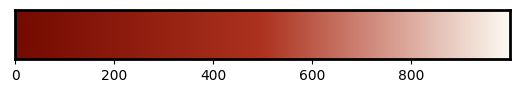

In [47]:
dispmap([shuan,palette[2],shironeri])

In [48]:

cm = makemap([palette[2],shironeri])
norm = clrs.Normalize(vmin=3,vmax=8)
cb_CO = cmap.ScalarMappable(cmap=cm, norm=norm)
cb_CO.set_array([])


<ipython-input-49-2658930e566e>:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


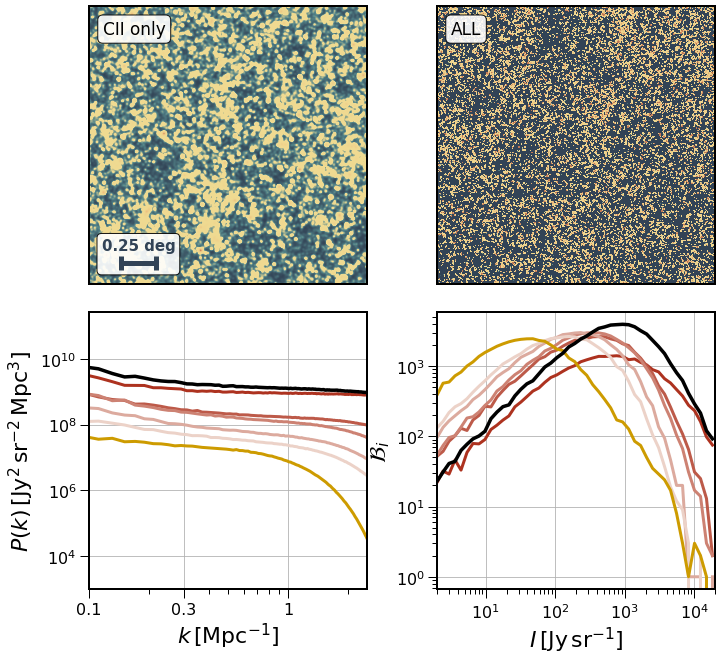

In [49]:
gs_plot = gridspec.GridSpec(2,2,left=0.12,bottom=0.09,right=0.99,top=0.99,
                            wspace=.25,hspace=.1)#,height_ratios=[2,1])
fig = plt.figure(figsize=(10,9))

norm = clrs.TwoSlopeNorm(vcenter=0)#,vmin=np.min(ALL_map),vmax=np.max(ALL_map))
######## MAPS ########

#gs_plot2 = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs_plot[:-1,:],hspace=0.1,wspace=0.25,height_ratios=[8,1])

ax = plt.subplot(gs_plot[0,0])
#norm = clrs.TwoSlopeNorm(vcenter=0,vmin=np.min(CO_J43_map.preview(axes=[2,1]),vmax=np.max(np.max(CO_J43_map.preview(axes=[2,1]))))

cb = ax.imshow(CII_L18_map.preview(axes=[1,2]), extent=[x[0],x[-1], y[-1], y[0]], cmap=gabimap,norm=norm,aspect='auto')
#plt.xlabel('Mpc/h')
ax.text(10,10,'CII only', bbox=dict(boxstyle="round",facecolor='white', alpha=0.9),ha='left',va='top',fontsize=17)
ax.set_xticks([])
ax.set_yticks([])
rside = x[-1]-x[0]
side = rside/16
cent = 20+side+3
ax.text(cent,190,'0.25 deg\n', color=aonibi,weight='bold',ha='center',va='bottom',fontsize=15,bbox=dict(boxstyle="round",facecolor='white', alpha=0.9))
ax.errorbar(cent,185,xerr=side,marker='',ls='--',c=aonibi,elinewidth=5,capsize=7,capthick=5,zorder=10)
#rside = x[-1]-x[0]
#cent = rside/5
#side = rside/10
#ax.errorbar(cent,y[-1]-7,xerr=side,marker='',ls='--',c=shironeri,elinewidth=5,capsize=10,capthick=5)
#ax.text(cent,y[-1]-10,r'0.2 deg', color=shironeri,weight='bold',ha='center',va='bottom')

ax = plt.subplot(gs_plot[0,1])
#norm = clrs.TwoSlopeNorm(vcenter=0,vmin=np.min(CO_J65_map.preview(axes=[2,1])),vmax=np.max(np.max(CO_J65_map.preview(axes=[2,1]))))
ax.imshow(ALL_map.preview(axes=[1,2]), extent=[x[0],x[-1], y[-1], y[0]], cmap=gabimap,norm=norm,aspect='auto')
#plt.xlabel('Mpc/h')
ax.text(10,10,'ALL', bbox=dict(boxstyle="round",facecolor='white', alpha=0.9),ha='left',va='top',fontsize=17)
ax.set_xticks([])
ax.set_yticks([])

######### COLORBAR ##############

#cbar = plt.colorbar(cb,orientation='horizontal',cax=plt.subplot(gs_plot2[1,:]))
#cbar.ax.set_xlabel(r'$\delta I\, \left[{\rm Jy\,sr^{-1}}\right]$', fontsize=24,labelpad = 10)
#cbar.ax.tick_params(labelsize=19,size = 8.) 


######## PK ########

ax = plt.subplot(gs_plot[1,0])
ax.loglog(kCO_J32.to(u.Mpc**-1), PkCO_J32.to(LC.unit**2*u.Mpc**3),lw=3,c=cb_CO.to_rgba(3))
ax.loglog(kCO_J43.to(u.Mpc**-1), PkCO_J43.to(LC.unit**2*u.Mpc**3),lw=3,c=cb_CO.to_rgba(4))
ax.loglog(kCO_J54.to(u.Mpc**-1), PkCO_J54.to(LC.unit**2*u.Mpc**3),lw=3,c=cb_CO.to_rgba(5))
ax.loglog(kCO_J65.to(u.Mpc**-1), PkCO_J65.to(LC.unit**2*u.Mpc**3),lw=3,c=cb_CO.to_rgba(6))
ax.loglog(kCO_J76.to(u.Mpc**-1), PkCO_J76.to(LC.unit**2*u.Mpc**3),lw=3,c=cb_CO.to_rgba(7))
ax.loglog(kCII_L18.to(u.Mpc**-1), PkCII_L18.to(LC.unit**2*u.Mpc**3),lw=3,c=palette[1])
#ax.loglog(kCII_DL14.to(u.Mpc**-1), PkCII_DL14.to(LC.unit**2*u.Mpc**3))
ax.loglog(kALL.to(u.Mpc**-1), PkALL.to(LC.unit**2*u.Mpc**3),lw=3.5,color='k')
#ax.loglog(kALL_DL14.to(u.Mpc**-1), PkALL_DL14.to(LC.unit**2*u.Mpc**3),lw=4,color='k')

ax.tick_params(axis='both',width=1,length=9,labelsize=16)
ax.tick_params(axis='both',which='minor',width=1,length=5,labelsize=16)
ax.grid()
ax.set_xticks([0.1,0.3,1])
ax.set_xticklabels([0.1,0.3,1])
ax.set_xlim(0.1,2.5)
#ax.set_ylim(1e5,1e6)
ax.set_xlabel(r'$k\,[{\rm Mpc^{-1}}]$',fontsize=22)
ax.set_ylabel(r'$P(k)\,[{\rm Jy^2\,sr^{-2}\,Mpc^{3}}]$',fontsize=22)

######## VID #######

ax = plt.subplot(gs_plot[1,1])
ax.loglog(Ii_COJ32, VID_COJ32,lw=3,c=cb_CO.to_rgba(3))
ax.loglog(Ii_COJ43, VID_COJ43,lw=3,c=cb_CO.to_rgba(4))
ax.loglog(Ii_COJ54, VID_COJ54,lw=3,c=cb_CO.to_rgba(5))
ax.loglog(Ii_COJ65, VID_COJ65,lw=3,c=cb_CO.to_rgba(6))
ax.loglog(Ii_COJ76, VID_COJ76,lw=3,c=cb_CO.to_rgba(7))
ax.loglog(Ii_CII_L18, VID_CII_L18,lw=3,c=palette[1])
#ax.loglog(Ii_CII_DL14, VID_CII_DL14)
ax.loglog(Ii_ALL, VID_ALL,lw=3.5,color='k')
#ax.loglog(Ii_ALL_DL14, VID_ALL_DL14,lw=4,color='k')

ax.tick_params(axis='both',width=1,length=9,labelsize=16)
ax.tick_params(axis='both',which='minor',width=1,length=5,labelsize=16)
ax.grid()
ax.set_xlabel(r'$I\,[{\rm Jy\,sr^{-1}}]$',fontsize=22)
ax.set_ylabel(r'$\mathcal{B}_i$',fontsize=22)
ax.set_xlim(2,20000)
#ax.set_ylim(5,2000)
ax.set_xticks([10,100,1000,10000])

plt.tight_layout()
plt.savefig('LC_LIM_interloper_maps.pdf', dpi=200)
plt.show()

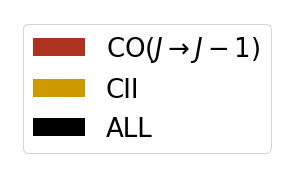

In [4]:

a = patches.Patch(facecolor=palette[2],alpha=1.)
b = patches.Patch(facecolor=palette[1],alpha=1.)
c = patches.Patch(facecolor='k',alpha=1)

plt.close()


fig = plt.figure(figsize=(5,3))
leg = fig.legend((a,b,c),(r'CO($J\rightarrow J-1$)','CII',r'ALL'),
                 loc='center',
           ncol=1, borderaxespad=0.,fontsize=26)


plt.axis('off')
plt.savefig('LC_legend.pdf')

In [73]:
######## PK ########

ax = plt.subplot(gs_plot[1,0])
ax.loglog(kCO_J32.to(u.Mpc**-1), PkCO_J32.to(LC.unit**2*u.Mpc**3),lw=2)
ax.loglog(kCO_J43.to(u.Mpc**-1), PkCO_J43.to(LC.unit**2*u.Mpc**3),lw=2)
ax.loglog(kCO_J54.to(u.Mpc**-1), PkCO_J54.to(LC.unit**2*u.Mpc**3),lw=2)
ax.loglog(kCO_J65.to(u.Mpc**-1), PkCO_J65.to(LC.unit**2*u.Mpc**3),lw=2)
ax.loglog(kCO_J76.to(u.Mpc**-1), PkCO_J76.to(LC.unit**2*u.Mpc**3),lw=2)
ax.loglog(kCII_L18.to(u.Mpc**-1), PkCII_L18.to(LC.unit**2*u.Mpc**3))
ax.loglog(kCII_DL14.to(u.Mpc**-1), PkCII_DL14.to(LC.unit**2*u.Mpc**3))
ax.loglog(kALL.to(u.Mpc**-1), PkALL.to(LC.unit**2*u.Mpc**3),lw=4,color='k')
ax.loglog(kALL_DL14.to(u.Mpc**-1), PkALL_DL14.to(LC.unit**2*u.Mpc**3),lw=4,color='k')

ax.tick_params(axis='both',width=1,length=9,labelsize=16)
ax.tick_params(axis='both',which='minor',width=1,length=5,labelsize=16)
ax.grid()
ax.set_xticks([0.1,0.3,1])
ax.set_xticklabels([0.1,0.3,1])
ax.set_xlim(0.1,2.5)
#ax.set_ylim(1e5,1e6)
ax.set_xlabel(r'$k\,[{\rm Mpc^{-1}}]$',fontsize=20)
ax.set_ylabel(r'$P(k)\,[{\rm Jy^2\,sr^{-2}\,Mpc^{3}}]$',fontsize=20)

######## VID #######

ax = plt.subplot(gs_plot[1,1])
ax.loglog(Ii_COJ32, VID_COJ32,lw=2)
ax.loglog(Ii_COJ43, VID_COJ43,lw=2)
ax.loglog(Ii_COJ54, VID_COJ54,lw=2)
ax.loglog(Ii_COJ65, VID_COJ65,lw=2)
ax.loglog(Ii_COJ76, VID_COJ76,lw=2)
ax.loglog(Ii_CII_L18, VID_CII_L18)
ax.loglog(Ii_CII_DL14, VID_CII_DL14)
ax.loglog(Ii_ALL, VID_ALL,lw=4,color='k')
ax.loglog(Ii_ALL_DL14, VID_ALL_DL14,lw=4,color='k')

ax.tick_params(axis='both',width=1,length=9,labelsize=16)
ax.tick_params(axis='both',which='minor',width=1,length=5,labelsize=16)
ax.grid()
ax.set_xlabel(r'$I\,[{\rm Jy\,sr^{-1}}]$',fontsize=20)
ax.set_ylabel(r'$\mathcal{B}_i$',fontsize=20)
ax.set_xlim(2,20000)
#ax.set_ylim(5,2000)
ax.set_xticks([10,100,1000,10000])

array([  0.        ,   0.26878664,   0.53757328,   0.80635992,
         1.07514656,   1.3439332 ,   1.61271985,   1.88150649,
         2.15029313,   2.41907977,   2.68786641,   2.95665305,
         3.22543969,   3.49422633,   3.76301297,   4.03179961,
         4.30058626,   4.5693729 ,   4.83815954,   5.10694618,
         5.37573282,   5.64451946,   5.9133061 ,   6.18209274,
         6.45087938,   6.71966602,   6.98845267,   7.25723931,
         7.52602595,   7.79481259,   8.06359923,   8.33238587,
         8.60117251,   8.86995915,   9.13874579,   9.40753243,
         9.67631908,   9.94510572,  10.21389236,  10.482679  ,
        10.75146564,  11.02025228,  11.28903892,  11.55782556,
        11.8266122 ,  12.09539884,  12.36418549,  12.63297213,
        12.90175877,  13.17054541,  13.43933205,  13.70811869,
        13.97690533,  14.24569197,  14.51447861,  14.78326525,
        15.05205189,  15.32083854,  15.58962518,  15.85841182,
        16.12719846,  16.3959851 ,  16.66477174,  16.93

# CO map at z=3

In [15]:
nu_CO=115.271*u.GHz
zmin_CO = 2.9
zmax_CO = 3.1

CO=make_measurements(dict(halo_lightcone_dir='/home/jlbernal/LightCone_S82_UM',
                          lines=dict(CO_J10=True),
                          target_line = 'CO_J10',
                          models=dict(CO_J10=dict(model_name='CO_lines_scaling_LFIR',
                                              model_pars={'alpha':1.09,'alpha_std':0.04,'beta':-1,'beta_std':0.4,'sigma_L':0.3})),
                          do_external_SFR = False, external_SFR = '',
                          SFR_pars=dict(),
                          supersample=20,
                          Nmu=10,
                          dk=0.02*u.Mpc**-1,
                          zmin = zmin_CO-0.03, zmax = zmax_CO+0.03,
                          RAObs_min=-0.5*u.deg,RAObs_max=0.5*u.deg,
                          DECObs_min=-0.5*u.deg,DECObs_max=0.5*u.deg,
                          RA_min=-0.5*u.deg,RA_max=0.5*u.deg,
                          DEC_min=-0.5*u.deg,DEC_max=0.5*u.deg,
                          nuObs_max=nu_CO/(1+zmin_CO), nuObs_min=nu_CO/(1+zmax_CO),
                          beam_FWHM=4*u.arcmin,
                          dnu=31.25*u.MHz,
                          Tsys=0*u.K, 
                          Nfeeds=1000,
                          tobs=10000*u.hr,
                          linear_VID_bin=False, Tmin_VID = 1.0e-4*u.uK,
                          do_angular_smooth=True,
                          seed = 1213,do_intensity=False,do_downsample=False))

In [27]:
LC.nuObs_min,LC.nuObs_max

(<Quantity 292.39061538 GHz>, <Quantity 345.55254545 GHz>)

In [84]:
np.mean(CO_J43_map),np.min(CO_J43_map),np.max(CO_J43_map)

(-4.421296e-06, -1731658.2, 67509280.0)

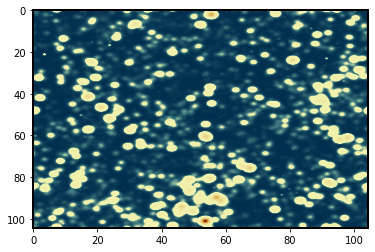

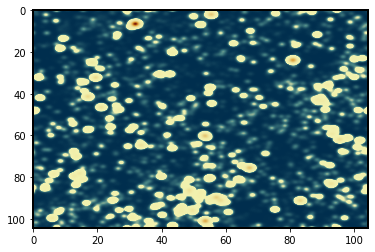

In [27]:
norm = clrs.TwoSlopeNorm(vcenter=0)
plt.imshow((ALL_map-np.mean(ALL_map)).preview(axes=[2,1]), extent=[x[0],x[-1], y[-1], y[0]], cmap=map_br,norm=norm,aspect='auto')
plt.show()
norm = clrs.TwoSlopeNorm(vcenter=0)
plt.imshow((CII_map-np.mean(CII_map)).preview(axes=[2,1]), extent=[x[0],x[-1], y[-1], y[0]], cmap=map_br,norm=norm,aspect='auto')
plt.show()

# tests

In [16]:
zmin,zmax = 4.89,5.11
nu_CII=1900.539*u.GHz
zmin_CIIobs,zmax_CIIobs = 4.9,5.1
LC=make_measurements(dict(halo_lightcone_dir='/home/jlbernal/LightCone_S82_UM',
                          target_line = 'CII',
                          lines=dict(CII=True),
                          models=dict(CII=dict(model_name='CII_Lagache18',
                          model_pars={'alpha1':1.4,'alpha2':-0.07, 'beta1':7.1, 'beta2':-0.07,'sigma_L':0.3})),
                          do_external_SFR = False, external_SFR = '',
                          SFR_pars=dict(),
                          supersample=10,
                          Nmu=20,
                          dk=0.02*u.Mpc**-1,
                          zmin = zmin, zmax = zmax,
                          RAObs_min=-5*u.deg,RAObs_max=5*u.deg,
                          DECObs_min=-5*u.deg,DECObs_max=5*u.deg,
                          RA_min=-5*u.deg,RA_max=5*u.deg,
                          DEC_min=-5*u.deg,DEC_max=5*u.deg,
                          nuObs_max=nu_CII/(1+zmin_CIIobs), nuObs_min=nu_CII/(1+zmax_CIIobs),
                          beam_FWHM=55*u.arcsec,
                          dnu=2.2*u.GHz,
                          Tsys=0*u.K, 
                          Nfeeds=1000,
                          tobs=10000*u.hr,
                          linear_VID_bin=False, Tmin_VID = 1.0e-4*u.uK,
                          do_angular_smooth=True,
                         seed=1234,do_intensity=True,do_downsample=False,do_remove_mean=False))


In [17]:
np.mean(LC.obs_3d_map)

/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_215.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_216.fits


69.97079

In [197]:
LC.update(lines=dict(CII=True),
        models=dict(CII=dict(model_name='CII_Lagache18',
        model_pars={'alpha1':1.4,'alpha2':0.07, 'beta1':7.1, 'beta2':0.07,'sigma_L':0.3})))

array([[  22.755516, 1429.5217  , 3808.8088  , ..., -160.58624 ,
        -246.24307 , -245.16576 ],
       [-244.89465 ,  556.9852  , 1935.5895  , ..., -174.34436 ,
         -36.75921 , -201.15775 ],
       [-297.90955 ,   69.610176,  899.9127  , ..., -156.27101 ,
         192.39024 ,  -72.28958 ],
       ...,
       [ 118.079185,  -83.95428 , -170.55472 , ..., -279.24908 ,
        -402.875   , -173.5139  ],
       [ 884.5363  ,  297.93707 , -116.601326, ..., -418.69058 ,
        -378.00687 ,  209.12885 ],
       [ 582.09955 ,  847.16754 , 1630.1234  , ..., -302.89478 ,
        -323.61548 ,   38.462925]], dtype=float32)

In [28]:
CII_map/(CO_J43_map+CO_J65_map+CII_map)

/home/jlbernal/.conda/envs/py3/lib/python3.8/site-packages/pmesh/pm.py:188: RuntimeWarning: divide by zero encountered in true_divide
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jlbernal/.conda/envs/py3/lib/python3.8/site-packages/pmesh/pm.py:188: RuntimeWarning: invalid value encountered in true_divide
  result = getattr(ufunc, method)(*inputs, **kwargs)


RealField:array([[[ 2.8379428e+00,  4.2760870e+02, -2.6706390e+00, ...,
          1.1593071e+00,  1.3103060e+00,  1.6507313e+00],
        [ 2.7542677e-02,  4.2959128e-02,  3.9975015e-03, ...,
          1.1528856e+00,  2.0768738e+00, -4.5992184e-01],
        [ 4.1386625e-01,  2.9453853e-01,  1.9135432e-01, ...,
          1.3446320e+00,  4.5165226e-01,  5.1351672e-01],
        ...,
        [ 1.7342563e+00,  1.5553261e+00,  1.3907490e+00, ...,
          1.4652114e+00,  1.6780879e+00,  1.7956657e+00],
        [ 1.5861373e+00,  1.5435798e+00,  1.4811854e+00, ...,
          1.3145787e+00,  1.4614123e+00,  1.5693099e+00],
        [ 1.7343875e+00,  2.0088835e+00,  2.4501150e+00, ...,
          1.2418448e+00,  1.3842964e+00,  1.5476018e+00]],

       [[ 1.0029831e+00,  1.0047362e+00,  1.0044374e+00, ...,
          1.0260593e+00,  1.0118498e+00,  1.0027683e+00],
        [ 1.0341748e+00,  1.0225055e+00,  1.0103621e+00, ...,
          1.0668896e+00,  1.0564027e+00,  1.0470349e+00],
        [ 1.100

In [22]:
np.mean(ALL_map)/np.mean(CII_map)

0.9322858

In [21]:
np.mean(CII_map)

1238.7247

In [48]:
ALL_map/(CO_J43_map+CO_J65_map+CII_map)

RealField:array([[[0.9272819 , 0.9272846 , 0.92728734, ..., 0.92727524,
         0.92727715, 0.9272794 ],
        [0.9272853 , 0.9272885 , 0.9272917 , ..., 0.92727757,
         0.9272797 , 0.9272823 ],
        [0.92728573, 0.9272892 , 0.9272928 , ..., 0.927278  ,
         0.9272801 , 0.92728275],
        ...,
        [0.92728   , 0.9272817 , 0.92728317, ..., 0.92727506,
         0.9272766 , 0.92727834],
        [0.92728114, 0.9272829 , 0.9272848 , ..., 0.92727566,
         0.9272774 , 0.92727935],
        [0.9272816 , 0.92728364, 0.9272856 , ..., 0.92727625,
         0.927278  , 0.9272798 ]],

       [[0.9272766 , 0.92727566, 0.9272745 , ..., 0.92727685,
         0.92727715, 0.9272771 ],
        [0.92727697, 0.9272763 , 0.9272753 , ..., 0.9272767 ,
         0.92727727, 0.92727727],
        [0.9272761 , 0.92727536, 0.92727435, ..., 0.92727596,
         0.9272763 , 0.92727643],
        ...,
        [0.9272744 , 0.92727274, 0.92727107, ..., 0.9272779 ,
         0.9272772 , 0.927276  ],
  

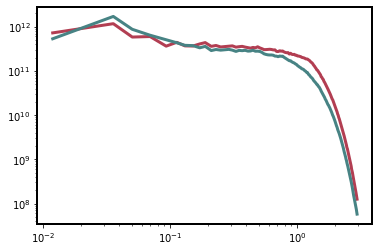

In [24]:
plt.loglog(kCII.to(u.Mpc**-1), PkCII.to(LC.unit**2*u.Mpc**3))
plt.loglog(kALL.to(u.Mpc**-1), PkALL.to(LC.unit**2*u.Mpc**3)/0.9322858**2)


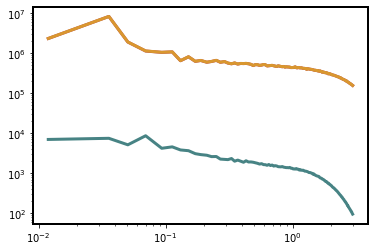

In [47]:
plt.loglog(kCO_J43.to(u.Mpc**-1), PkCO_J43.to(LC.unit**2*u.Mpc**3))
plt.loglog(kCO_J65.to(u.Mpc**-1), PkCO_J65.to(LC.unit**2*u.Mpc**3))
plt.loglog(kCO_J65.to(u.Mpc**-1), PkCO_J65.to(LC.unit**2*u.Mpc**3)+PkCO_J43.to(LC.unit**2*u.Mpc**3))
#plt.loglog(kCII.to(u.Mpc**-1), PkCII.to(LC.unit**2*u.Mpc**3))
#plt.loglog(kALL.to(u.Mpc**-1), PkALL.to(LC.unit**2*u.Mpc**3))
#plt.loglog(kALL.to(u.Mpc**-1), PkCO_J43.to(LC.unit**2*u.Mpc**3)+PkCO_J65.to(LC.unit**2*u.Mpc**3)+PkCII.to(LC.unit**2*u.Mpc**3))
#plt.ylim(1e10,1e13)


In [ ]:

VID_COJ43 = np.histogram(CO_J43_map.flatten(),
                            bins=self.Ti_edge.value)[0]

In [13]:
LC.update(lines=dict(CO_J65=True),
          models=dict(CO_J65=dict(model_name='CO_lines_scaling_LFIR',
                                  model_pars={'alpha':1.04,'alpha_std':0.033,'beta':2.2,'beta_std':0.2,'sigma_L':0.3})))


In [14]:
CO_J43_map=LC.obs_3d_map


{'CO_J65': True}

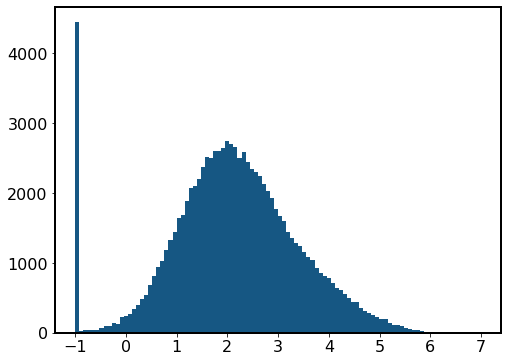

In [32]:
plt.hist(np.log10(LC.halos_in_survey['CO_J43']['Lhalo'].value+0.1),bins=100)
plt.show()

In [76]:
LC.lines

{'CO_J65': True, 'CO_J43': True, 'CII': True}

In [156]:
#Define the mesh divisions and the box size
Nmesh = np.array([LC.supersample*LC.Nchan,
          LC.supersample*LC.Nside[0],
          LC.supersample*LC.Nside[1]], dtype=int)
Lbox = LC.Lbox.value

ralim = np.deg2rad(np.array([LC.RAObs_min.value,LC.RAObs_max.value]))
declim = np.deg2rad(np.array([LC.DECObs_min.value,LC.DECObs_max.value]))
raside_lim = LC.raside_lim
decside_lim = LC.decside_lim
rside_obs_lim = LC.rside_obs_lim

ramid = 0.5*(LC.RAObs_max + LC.RAObs_min)
decmid = 0.5*(LC.DECObs_max + LC.DECObs_min)

mins_obs = np.array([rside_obs_lim[0],raside_lim[0],decside_lim[0]])

global sigma_par
global sigma_perp
maps = np.zeros([Nmesh[0],Nmesh[1],Nmesh[2]//2 + 1], dtype='complex64')


# First, compute the intensity/temperature of each halo in the catalog we will include
for line in LC.lines.keys():
    if line == 'CII':

        print('a')
        #Get true cell volume
        zlims = (LC.line_nu0[line].value)/np.array([LC.nuObs_max.value,LC.nuObs_min.value])-1
        rlim = ((LC.cosmo.comoving_radial_distance(zlims)*u.Mpc).to(LC.Mpch)).value
        #Get the side of the box
        if LC.do_inner_cut:
            raside = 2*rlim[0]*np.tan(0.5*(ralim[1]-ralim[0]))
            decside = 2*rlim[0]*np.tan(0.5*(declim[1]-declim[0]))
            zside = rlim[1]*np.cos(max(0.5*(ralim[1]-ralim[0]),0.5*(declim[1]-declim[0])))-rlim[0]
            rside_lim = np.array([rlim[0],rlim[0]+zside])
        else:
            raside = 2*rlim[1]*np.tan(0.5*(ralim[1]-ralim[0]))
            decside = 2*rlim[1]*np.tan(0.5*(declim[1]-declim[0]))
            zside = rlim[1]-rlim[0]*np.cos(max(0.5*(ralim[1]-ralim[0]),0.5*(declim[1]-declim[0])))
            rside_lim = np.array([rlim[1]-zside,rlim[1]])

        Lbox_true = np.array([zside,raside,decside])
        Vcell_true = (Lbox_true/Nmesh).prod()*(LC.Mpch**3).to(LC.Mpch**3)
        #Get positions using the observed redshift
        #Convert the halo position in each volume to Cartesian coordinates (from Nbodykit)
        ra,dec,redshift = da.broadcast_arrays(LC.halos_in_survey[line]['RA'], LC.halos_in_survey[line]['DEC'],
                                              LC.halos_in_survey[line]['Zobs'])

        #Shift the ra and dec of the halo such that they are centered in (0,0)
        ra -= ramid.value
        dec -= decmid.value

        ra,dec  = da.deg2rad(ra),da.deg2rad(dec)

        # cartesian coordinates
        x = da.cos(dec) * da.cos(ra)
        y = da.cos(dec) * da.sin(ra)
        z = da.sin(dec)
        pos = da.vstack([x,y,z]).T
        #radial distances in Mpch/h
        r = redshift.map_blocks(lambda zz: (((LC.cosmo.comoving_radial_distance(zz)*u.Mpc).to(LC.Mpch)).value),
                                dtype=redshift.dtype)
        cartesian_halopos = r[:,None] * pos
        lategrid = np.array(cartesian_halopos.compute())
        #Filter some halos out if outside of the inner cut
        if LC.do_inner_cut:
            filtering = (lategrid[:,0] >= rside_obs_lim[0]) & (lategrid[:,0] < rside_obs_lim[1]) & \
                        (lategrid[:,1] >= raside_lim[0]) & (lategrid[:,1] < raside_lim[1]) & \
                        (lategrid[:,2] >= decside_lim[0]) & (lategrid[:,2] < decside_lim[1])
            lategrid = lategrid[filtering]
            #Compute the signal in each voxel (with Ztrue and Vcell_true)
            Zhalo = LC.halos_in_survey[line]['Ztrue'][filtering]
            Hubble = LC.cosmo.hubble_parameter(Zhalo)*(u.km/u.Mpc/u.s)
            if LC.do_intensity:
                #intensity[Jy/sr]
                signal = (cu.c/(4.*np.pi*LC.line_nu0[line]*Hubble*(1.*u.sr))*LC.halos_in_survey[line]['Lhalo'][filtering]/Vcell_true).to(LC.unit)
            else:
                #Temperature[uK]
                signal = (cu.c**3*(1+Zhalo)**2/(8*np.pi*cu.k_B*LC.line_nu0[line]**3*Hubble)*LC.halos_in_survey[line]['Lhalo'][filtering]/Vcell_true).to(LC.unit)
        else:
            Zhalo = LC.halos_in_survey[line]['Ztrue']
            Hubble = LC.cosmo.hubble_parameter(Zhalo)*(u.km/u.Mpc/u.s)
            if LC.do_intensity:
                #intensity[Jy/sr]
                signal = (cu.c/(4.*np.pi*LC.line_nu0[line]*Hubble*(1.*u.sr))*LC.halos_in_survey[line]['Lhalo']/Vcell_true).to(LC.unit)
            else:
                #Temperature[uK]
                signal = (cu.c**3*(1+Zhalo)**2/(8*np.pi*cu.k_B*LC.line_nu0[line]**3*Hubble)*LC.halos_in_survey[line]['Lhalo']/Vcell_true).to(LC.unit)
        #Locate the grid such that bottom left corner of the box is [0,0,0] which is the nbodykit convention.
        mins = np.array([rside_obs_lim[0],raside_lim[0],decside_lim[0]])
        for n in range(3):
            lategrid[:,n] -= mins[n]
        #Set the emitter in the grid and paint using pmesh directly instead of nbk
        pm = pmesh.pm.ParticleMesh(Nmesh, BoxSize=Lbox, dtype='float32', resampler='cic')
        #Make realfield object
        field = pm.create(type='real')
        layout = pm.decompose(lategrid)
        #Exchange positions between different MPI ranks
        p = layout.exchange(lategrid)
        #Assign weights following the layout of particles
        m = layout.exchange(signal.value)
        if LC.mass:
            pm.paint(p, out=field, mass=1, resampler='cic')
        else: 
            pm.paint(p, out=field, mass=m, resampler='cic')
        #Fourier transform fields and apply the filter
        field = field.r2c()
        #This smoothing comes from the resolution window function.
        if LC.do_spectral_smooth or LC.do_angular_smooth:
            #compute scales for the anisotropic filter (in Ztrue -> zmid)
            zmid = (LC.line_nu0[line]/LC.nuObs_mean).decompose().value-1
            sigma_par = LC.do_spectral_smooth*(cu.c*LC.dnu*(1+zmid)/(LC.cosmo.hubble_parameter(zmid)*(u.km/u.Mpc/u.s)*LC.nuObs_mean)).to(LC.Mpch).value
            sigma_perp = LC.do_angular_smooth*(LC.cosmo.comoving_radial_distance(zmid)*u.Mpc*(LC.beam_width/(1*u.rad))).to(LC.Mpch).value
            field = field.apply(aniso_filter, kind='wavenumber')
        #Add this contribution to the total maps
        maps+=field

a


In [124]:
LC.lines

{'CII': True}

In [130]:
#Define the mesh divisions and the box size
Nmesh = np.array([LC.supersample*LC.Nchan,
          LC.supersample*LC.Nside[0],
          LC.supersample*LC.Nside[1]], dtype=int)
Lbox = LC.Lbox.value

ralim = np.deg2rad(np.array([LC.RAObs_min.value,LC.RAObs_max.value]))
declim = np.deg2rad(np.array([LC.DECObs_min.value,LC.DECObs_max.value]))
raside_lim = LC.raside_lim
decside_lim = LC.decside_lim
rside_obs_lim = LC.rside_obs_lim

ramid = 0.5*(LC.RAObs_max + LC.RAObs_min)
decmid = 0.5*(LC.DECObs_max + LC.DECObs_min)

mins_obs = np.array([rside_obs_lim[0],raside_lim[0],decside_lim[0]])

global sigma_par
global sigma_perp
maps = np.zeros([Nmesh[0],Nmesh[1],Nmesh[2]//2 + 1], dtype='complex64')


# First, compute the intensity/temperature of each halo in the catalog we will include
for line in LC.lines.keys():
    if LC.lines[line]:
        print(line)
        #Get true cell volume
        zlims = (LC.line_nu0[line].value)/np.array([LC.nuObs_max.value,LC.nuObs_min.value])-1
        rlim = ((LC.cosmo.comoving_radial_distance(zlims)*u.Mpc).to(LC.Mpch)).value
        #Get the side of the box
        if LC.do_inner_cut:
            raside = 2*rlim[0]*np.tan(0.5*(ralim[1]-ralim[0]))
            decside = 2*rlim[0]*np.tan(0.5*(declim[1]-declim[0]))
            zside = rlim[1]*np.cos(max(0.5*(ralim[1]-ralim[0]),0.5*(declim[1]-declim[0])))-rlim[0]
            rside_lim = np.array([rlim[0],rlim[0]+zside])
        else:
            raside = 2*rlim[1]*np.tan(0.5*(ralim[1]-ralim[0]))
            decside = 2*rlim[1]*np.tan(0.5*(declim[1]-declim[0]))
            zside = rlim[1]-rlim[0]*np.cos(max(0.5*(ralim[1]-ralim[0]),0.5*(declim[1]-declim[0])))
            rside_lim = np.array([rlim[1]-zside,rlim[1]])

        Lbox_true = np.array([zside,raside,decside])
        Vcell_true = (Lbox_true/Nmesh).prod()*(LC.Mpch**3).to(LC.Mpch**3)
        #Get positions using the observed redshift
        #Convert the halo position in each volume to Cartesian coordinates (from Nbodykit)
        ra,dec,redshift = da.broadcast_arrays(LC.halos_in_survey[line]['RA'], LC.halos_in_survey[line]['DEC'],
                                              LC.halos_in_survey[line]['Zobs'])

        #Shift the ra and dec of the halo such that they are centered in (0,0)
        ra -= ramid.value
        dec -= decmid.value

        ra,dec  = da.deg2rad(ra),da.deg2rad(dec)

        # cartesian coordinates
        x = da.cos(dec) * da.cos(ra)
        y = da.cos(dec) * da.sin(ra)
        z = da.sin(dec)
        pos = da.vstack([x,y,z]).T
        #radial distances in Mpch/h
        r = redshift.map_blocks(lambda zz: (((LC.cosmo.comoving_radial_distance(zz)*u.Mpc).to(LC.Mpch)).value),
                                dtype=redshift.dtype)
        cartesian_halopos = r[:,None] * pos
        lategrid = np.array(cartesian_halopos.compute())
        #Filter some halos out if outside of the inner cut
        if LC.do_inner_cut:
            filtering = (lategrid[:,0] >= rside_obs_lim[0]) & (lategrid[:,0] < rside_obs_lim[1]) & \
                        (lategrid[:,1] >= raside_lim[0]) & (lategrid[:,1] < raside_lim[1]) & \
                        (lategrid[:,2] >= decside_lim[0]) & (lategrid[:,2] < decside_lim[1])
            lategrid = lategrid[filtering]
            #Compute the signal in each voxel (with Ztrue and Vcell_true)
            Zhalo = LC.halos_in_survey[line]['Ztrue'][filtering]
            Hubble = LC.cosmo.hubble_parameter(Zhalo)*(u.km/u.Mpc/u.s)
            if LC.do_intensity:
                #intensity[Jy/sr]
                signal = (cu.c/(4.*np.pi*LC.line_nu0[line]*Hubble*(1.*u.sr))*LC.halos_in_survey[line]['Lhalo'][filtering]/Vcell_true).to(LC.unit)
            else:
                #Temperature[uK]
                signal = (cu.c**3*(1+Zhalo)**2/(8*np.pi*cu.k_B*LC.line_nu0[line]**3*Hubble)*LC.halos_in_survey[line]['Lhalo'][filtering]/Vcell_true).to(LC.unit)
        else:
            Zhalo = LC.halos_in_survey[line]['Ztrue']
            Hubble = LC.cosmo.hubble_parameter(Zhalo)*(u.km/u.Mpc/u.s)
            if LC.do_intensity:
                #intensity[Jy/sr]
                signal = (cu.c/(4.*np.pi*LC.line_nu0[line]*Hubble*(1.*u.sr))*LC.halos_in_survey[line]['Lhalo']/Vcell_true).to(LC.unit)
            else:
                #Temperature[uK]
                signal = (cu.c**3*(1+Zhalo)**2/(8*np.pi*cu.k_B*LC.line_nu0[line]**3*Hubble)*LC.halos_in_survey[line]['Lhalo']/Vcell_true).to(LC.unit)
        #Locate the grid such that bottom left corner of the box is [0,0,0] which is the nbodykit convention.
        mins = np.array([rside_obs_lim[0],raside_lim[0],decside_lim[0]])
        for n in range(3):
            lategrid[:,n] -= mins[n]
        #Set the emitter in the grid and paint using pmesh directly instead of nbk
        pm = pmesh.pm.ParticleMesh(Nmesh, BoxSize=Lbox, dtype='float32', resampler='cic')
        #Make realfield object
        field = pm.create(type='real')
        layout = pm.decompose(lategrid)
        #Exchange positions between different MPI ranks
        p = layout.exchange(lategrid)
        #Assign weights following the layout of particles
        m = layout.exchange(signal.value)
        if LC.mass:
            pm.paint(p, out=field, mass=1, resampler='cic')
        else: 
            pm.paint(p, out=field, mass=m, resampler='cic')
        #Fourier transform fields and apply the filter
        field = field.r2c()
        #This smoothing comes from the resolution window function.
        if LC.do_spectral_smooth or LC.do_angular_smooth:
            #compute scales for the anisotropic filter (in Ztrue -> zmid)
            zmid = (LC.line_nu0[line]/LC.nuObs_mean).decompose().value-1
            sigma_par = LC.do_spectral_smooth*(cu.c*LC.dnu*(1+zmid)/(LC.cosmo.hubble_parameter(zmid)*(u.km/u.Mpc/u.s)*LC.nuObs_mean)).to(LC.Mpch).value
            sigma_perp = LC.do_angular_smooth*(LC.cosmo.comoving_radial_distance(zmid)*u.Mpc*(LC.beam_width/(1*u.rad))).to(LC.Mpch).value
            field = field.apply(aniso_filter, kind='wavenumber')
        #Add this contribution to the total maps
        maps+=field

CII


In [157]:
aaa = maps.c2r()
bbb = aaa - aaa.cmean()

In [92]:
from nbodykit.algorithms import FFTPower


In [104]:
LC.update(lines=dict(CII=True),
        models=dict(CII=dict(model_name='CII_Lagache18',
        model_pars={'alpha1':1.4,'alpha2':0.07, 'beta1':7.1, 'beta2':0.07,'sigma_L':0.3})))

In [140]:
pk2d_cii=LC.Pk_2d


In [158]:
pk2d = FFTPower(aaa, '2d', Nmu=LC.Nmu, poles=[0,2,4], los=[1,0,0],
                                dk=LC.dk.to(LC.Mpch**-1).value,kmin=LC.kmin.to(LC.Mpch**-1).value,
                                kmax=LC.kmax.to(LC.Mpch**-1).value,BoxSize=LC.Lbox.value)
#pk2d_b = FFTPower(bbb, '2d', Nmu=LC.Nmu, poles=[0,2,4], los=[1,0,0],
#                                dk=LC.dk.to(LC.Mpch**-1).value,kmin=LC.kmin.to(LC.Mpch**-1).value,
#                                kmax=LC.kmax.to(LC.Mpch**-1).value,BoxSize=LC.Lbox.value)

(100000000.0, 10000000000000.0)

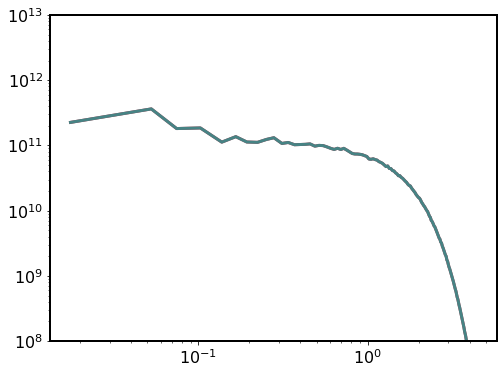

In [159]:
plt.loglog(pk2d.poles['k'],pk2d.poles['power_0'].real)
#plt.loglog(pk2d_b.poles['k'],pk2d_b.poles['power_0'].real)
plt.loglog(pk2d_cii.poles['k'],pk2d_cii.poles['power_0'].real)

plt.ylim(1e8,1e13)

In [100]:
len(LC.halos_in_survey['CO_J43']['Lhalo'][LC.halos_in_survey['CO_J43']['Lhalo'].value>0])

89665

In [130]:
raside

34.556905063357505

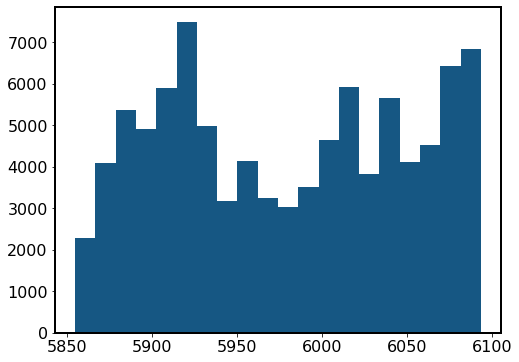

In [98]:
plt.hist(np.array(cartesian_halopos.compute())[:,0],bins=20)
plt.show()

In [79]:
np.array(cartesian_halopos.compute())

array([[5860.15396566,   49.25980441,   14.41247893],
       [5859.28504112,   49.2541523 ,   14.49441315],
       [5860.60863649,   48.43136477,   15.15863317],
       ...,
       [6092.66787856,  -28.37051481,   41.82511353],
       [6092.05630434,  -24.84810174,   37.74642247],
       [6092.65439572,  -24.17984244,   45.56065012]])

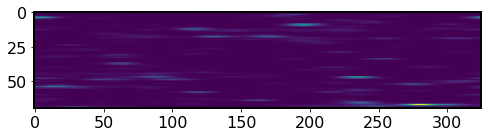

In [143]:
plt.imshow(maps[:,:,10])

In [35]:
getattr(LM,LC.models['CO_J43']['model_name'])(LC,SFR,LC.models['CO_J43']['model_pars'],LC.rng)

/home/jlbernal/preLIMinary/source/line_models.py:72: RuntimeWarning: divide by zero encountered in log10
  Lp = 10**((np.log10(LIR.value)-beta_par)/alpha_par)


<Quantity [8.06759383e+05, 7.54183481e+02, 3.66351022e+01, ...,
           2.53514282e+03, 4.08426734e+00, 4.21315843e+01] solLum>

In [38]:
LIR = (SFR/4.5e-44*u.erg/u.s).to(u.Lsun)

In [84]:
pars = LC.models['CO_J43']['model_pars']
alpha,beta,alpha_std,beta_std,sigma_L = pars['alpha'],pars['beta'],pars['alpha_std'],pars['beta_std'],pars['sigma_L']

inds = np.where(SFR>0)
L = np.zeros(len(SFR))*u.Lsun
LIR = (SFR[inds]*(1/4.5e-44)*u.erg/u.s).to(u.Lsun)

std = multivariate_normal(np.array([alpha,beta]),np.diag(np.array([alpha_std**2,beta_std**2])),LIR.shape)


alpha_par,beta_par = std[:,0],std[:,1]

Lp = 10**((np.log10(LIR.value)-beta_par)/alpha_par)

In [110]:
inds = np.where(SFR>0)
L = np.zeros(len(SFR))*u.Lsun
alpha,beta,alpha_std,beta_std,sigma_L = pars['alpha'],pars['beta'],pars['alpha_std'],pars['beta_std'],pars['sigma_L']

#Get the LIR from Kennicutt 1998, arXiv:9807187
LIR = SFR[inds]*(1/4.5e-44)*u.erg/u.s
LIR_norm = LIR*(1/1e41)

std = multivariate_normal(np.array([alpha,beta]),np.diag(np.array([alpha_std**2,beta_std**2])),LIR.shape)
alpha_par,beta_par = std[:,0],std[:,1]

Lerg_norm = 10**(alpha_par*np.log10(LIR_norm.value)-beta_par)
Lmean = (Lerg_norm*1e41*u.erg/u.s).to(u.Lsun)

#Add scatter to the relation
sigma_base_e = sigma_L*2.302585
L[inds] = Lmean*LC.rng.lognormal(-0.5*sigma_base_e**2, sigma_base_e, Lmean.shape)

In [124]:
grid_lim

array([[1942.84483253,  -16.95494999,  -16.95559561],
       [2464.71031847,   21.50920109,   21.51002013]])

In [8]:
ralim=np.asarray([LC.RAObs_min.value,LC.RAObs_max.value])
declim=np.asarray([LC.DECObs_min.value,LC.DECObs_max.value])
z_plot=np.asarray([LC.zmin, LC.zmax])
ra,dec  = np.deg2rad(ralim),np.deg2rad(declim)
x = np.cos(dec) * np.cos(ra)
y = np.cos(dec) * np.sin(ra)
z = np.sin(dec)
pos_lims = np.vstack([x,y,z]).T

r = ((LC.cosmo.comoving_radial_distance(z_plot)*u.Mpc).to(LC.Mpch)).value
grid_lim = r[:,None]*pos_lims

x=np.linspace(0, grid_lim[1,1]- grid_lim[0,1], LC.supersample*LC.Nside[0])
y=np.linspace(0, grid_lim[1,2]-grid_lim[0,2], LC.supersample*LC.Nside[1])

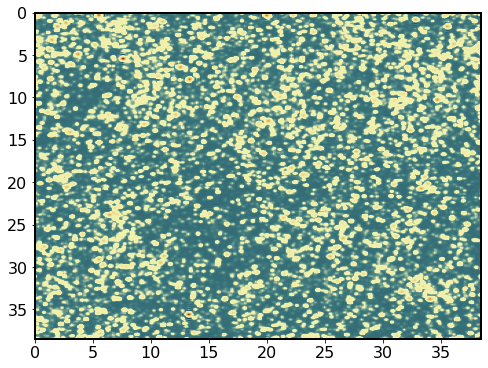

In [10]:
norm = clrs.TwoSlopeNorm(vcenter=0)
plt.imshow(CO_J43_map.preview(axes=[2,1]), extent=[x[0],x[-1], y[-1], y[0]], cmap=map_br,norm=norm,aspect='auto')


In [136]:
x

array([ 0.        ,  0.11871652,  0.23743303,  0.35614955,  0.47486606,
        0.59358258,  0.71229909,  0.83101561,  0.94973213,  1.06844864,
        1.18716516,  1.30588167,  1.42459819,  1.5433147 ,  1.66203122,
        1.78074774,  1.89946425,  2.01818077,  2.13689728,  2.2556138 ,
        2.37433031,  2.49304683,  2.61176335,  2.73047986,  2.84919638,
        2.96791289,  3.08662941,  3.20534592,  3.32406244,  3.44277895,
        3.56149547,  3.68021199,  3.7989285 ,  3.91764502,  4.03636153,
        4.15507805,  4.27379456,  4.39251108,  4.5112276 ,  4.62994411,
        4.74866063,  4.86737714,  4.98609366,  5.10481017,  5.22352669,
        5.34224321,  5.46095972,  5.57967624,  5.69839275,  5.81710927,
        5.93582578,  6.0545423 ,  6.17325882,  6.29197533,  6.41069185,
        6.52940836,  6.64812488,  6.76684139,  6.88555791,  7.00427443,
        7.12299094,  7.24170746,  7.36042397,  7.47914049,  7.597857  ,
        7.71657352,  7.83529004,  7.95400655,  8.07272307,  8.19

In [ ]:
LC.update(lines=dict(CO_J54=True),
          models=dict(CO_J54=dict(model_name='CO_lines_scaling_LFIR',
                        model_pars={'alpha':1.05,'alpha_std':0.03,'beta':1.8,'beta_std':0.3,'sigma_L':0.3})),)
CO_J54_map=LC.obs_3d_map
